Note: Data is limited to 2017–2018, as that is the publicly-available overlap.

In [189]:
# import cuml

# %load_ext cuml.accel

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 1000)

import matplotlib.pyplot as plt
import seaborn as sns
import re

from census import Census
from us import states

import censusdis.data as ced
from censusdis.datasets import ACS1_PROFILE
from censusdis import states

from statsmodels.formula.api import ols # for linear regression

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, roc_curve, auc

seed = 42

## Introduction

### Objective
To predict the size of demonstrations/protests based on metropolitan area demographics and the salience of the issue at hand.

### Impact
In recent years, protests in the US have grown in both number and scale. Being able to predict the scale of future protests would allow for a more efficient distribution of resources and would enable protesters, government institutions, first responders, and news organizations—among others—to better prepare for what is to come.

## Data Acquisition and Wrangling

### Results Dataset: Crowd Counting Consortium Phase 1 (2017-2020)

Our results dataset: Crowd Counting Consortium Phase 1 (2017-2020): https://ash.harvard.edu/programs/crowd-counting-consortium/

In [190]:
crowd_data_orig = pd.read_csv("C:/Users/alexa/Code/GW DATS/6103 12 Intro to Data Mining/Final Project/data/crowd_counting_consortium_2017-2020/ccc_compiled_20172020.csv",encoding_errors="replace")
crowd_data_orig.head(5)

C:\Users\alexa\AppData\Local\Temp\ipykernel_41016\1640917472.py:1: DtypeWarning: Columns (6,22,31,32,33,34,35,36,37,38,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  crowd_data_orig = pd.read_csv("C:/Users/alexa/Code/GW DATS/6103 12 Intro to Data Mining/Final Project/data/crowd_counting_consortium_2017-2020/ccc_compiled_20172020.csv",encoding_errors="replace")


date        locality state                 location_detail  online  \
0  2017-01-01      Washington    DC           Lafayette Square Park     0.0   
1  2017-01-01         Mankato    MN                             NaN     0.0   
2  2017-01-01     Minneapolis    MN               U.S. Bank Stadium     0.0   
3  2017-01-01  Little Compton    RI                      Town Green     0.0   
4  2017-01-01       Oak Ridge    TN  Y-12 National Security Complex     0.0   

                   type macroevent                                  actors  \
0                 vigil        NaN                                     NaN   
1                 vigil        NaN                     Peace Vigil Mankato   
2  protest; banner drop        NaN                      general protestors   
3                 vigil        NaN                 Sakonnet Peace Alliance   
4                 vigil        NaN  Oak Ridge Environmental Peace Alliance   

                                                                                                                 claims  \
0                                                                                for banning nuclear weapons, for peace   
1                                                                                                             for peace   
2  against the Dakota Access Pipeline, for indigenous rights, for environment, pressure US Bank to divest from pipeline   
3                                                                        for peace, for gun control, for climate action   
4                                                                                        for abolishing nuclear weapons   

   valence  ... source_28 source_29  source_30  \
0      0.0  ...       NaN       NaN        NaN   
1      0.0  ...       NaN       NaN        NaN   
2      1.0  ...       NaN       NaN        NaN   
3      1.0  ...       NaN       NaN        NaN   
4      0.0  ...       NaN       NaN        NaN   

                                                   notes        lat  \
0  White House Peace Vigil continuous since June 3, 1981  38.907192   
1                                every Sunday since 2001  44.163578   
2          hung banner from stadium roof during NFL game  44.977753   
3                                every Sunday since 2003  41.510103   
4                      every Sunday since the late 1990s  36.010356   

         lon resolved_locality       resolved_county resolved_state  fips_code  
0 -77.036871        Washington  District of Columbia             DC    11001.0  
1 -93.999400           Mankato     Blue Earth County             MN    27013.0  
2 -93.265011       Minneapolis       Hennepin County             MN    27053.0  
3 -71.171156    Little Compton        Newport County             RI    44005.0  
4 -84.269645         Oak Ridge       Anderson County             TN    47001.0  

[5 rows x 62 columns]

Only data for crowds that aren't online with a crowd size, information about what the crowd gathered for, and a FIPS code is kept. Also, the data is rid of `source` columns, as they are irrelevant for our purposes.

In [191]:
crowd_data = crowd_data_orig[(crowd_data_orig["issues"].notna()) & 
                             (crowd_data_orig["size_mean"].notna()) & 
                             (crowd_data_orig["fips_code"].notna()) &
                             (crowd_data_orig["online"] == 0) &
                             (crowd_data_orig["size_mean"] != 0) &
                             (crowd_data_orig["size_mean"].notna()) &
                             (crowd_data_orig["type"].notna())]
crowd_data = crowd_data.drop(columns=np.array(["source_"]*30)+np.arange(1,31).astype(str))
crowd_data.isna().sum()[crowd_data.isna().sum() > 0]


location_detail       2749
macroevent           32293
actors                1220
valence                 10
size_text             6536
size_high               33
arrests               3927
injuries_crowd        3985
injuries_police       3973
property_damage       3956
chemical_agents      30723
notes                29202
lat                      2
lon                      2
resolved_locality      340
resolved_county       1923
resolved_state          10
dtype: int64

In [192]:
# source_cols = np.array(["source_"]*30) + np.arange(1,31).astype(str)
# crowd_data.drop(columns=source_cols, inplace=True)
# crowd_data.head(5)
# crowd_data["fips_code"] = crowd_data["fips_code"].astype(np.int16)
# crowd_data["fips_code"]

crowd_data["year"] = crowd_data["date"].apply(lambda x:x[:4]).astype(int)
crowd_data["year"]


2        2017
8        2017
13       2017
14       2017
16       2017
         ... 
72155    2020
72156    2020
72167    2020
72168    2020
72172    2020
Name: year, Length: 33467, dtype: int64

The data is limited to the years 2017 and 2018, as that is the overlap we have available to us in these three datasets.

In [193]:
crowd_data = crowd_data[(crowd_data["year"] == 2017) | (crowd_data["year"] == 2018)]

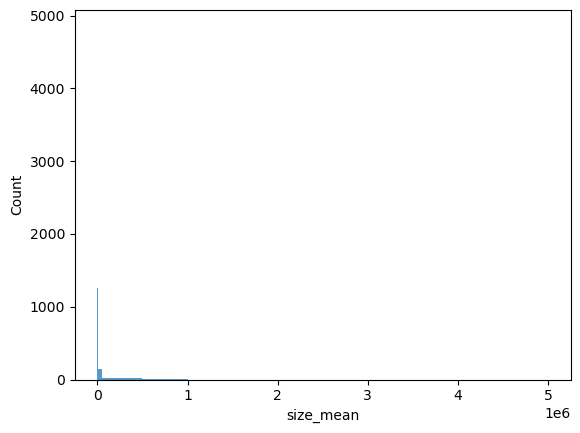

In [205]:
sns.histplot(data=crowd_data, x="size_mean", bins=[0, 5, 10, 20, 50, 100, 250, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000, 5000000])
plt.show()

As is to be expected, the data is extremely right-skewed. A column is added for `log_size_mean`, for a target variable that more closely approximates a normal distribution (as is assumed by e.g. linear regression).

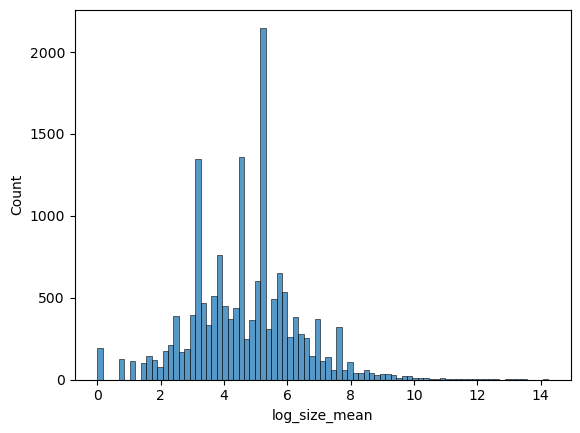

In [206]:
crowd_data["log_size_mean"] = crowd_data["size_mean"].apply(np.log)
sns.histplot(data=crowd_data, x="log_size_mean")
plt.show()

It is still right-skewed, but much better. 

Next, let us correct the FIPS codes.

In [87]:
print(crowd_data["fips_code"].isna().sum(), "out of", len(crowd_data))

0 out of 16703


There are 0 unresolved localities out of 16703; we need not discard any data and may proceed to cast the column as strings.

In [88]:
# crowd_data = crowd_data[crowd_data["fips_code"].notna()]
crowd_data["fips_code"] = crowd_data["fips_code"].astype(int).astype(str).str.rjust(5,"0").astype("category")
crowd_data["fips_code"]

2        27053
8        12086
13       26161
14       38085
16       36061
         ...  
32405    37081
32413    01101
32415    17031
32424    30087
32426    39035
Name: fips_code, Length: 16703, dtype: category
Categories (1316, object): ['01003', '01007', '01015', '01041', ..., '56041', '66000', '72000', '78000']

Many of these columns are unused in the final product; we shall reindex to the requisite columns.

In [207]:
crowd_data = crowd_data[["year","fips_code","type","issues","claims","size_mean", "log_size_mean", "size_cat"]]
crowd_data.head(5)

year  fips_code                     type  \
2   2017    27053.0     protest; banner drop   
8   2017    12086.0            demonstration   
13  2017    26161.0                  protest   
14  2017    38085.0  protest; occupying land   
16  2017    36061.0                  protest   

                                                                   issues  \
2   banking and finance; economy; energy; environment; indigenous peoples   
8                                                                policing   
13                                                      education; racism   
14                                                    energy; environment   
16                                                             presidency   

                                                                                                                  claims  \
2   against the Dakota Access Pipeline, for indigenous rights, for environment, pressure US Bank to divest from pipeline   
8                                     in remembrance of Jamal Rollins, against police brutality, for police transparency   
13          against racial incidents on campus, for pressuring university administration to do something, against racism   
14                                                              for environmental rights, against Dakota Access Pipeline   
16                                                                      against Trump's campaign and upcoming presidency   

    size_mean  log_size_mean  size_cat  
2         2.0       0.693147         1  
8        18.0       2.890372         1  
13      200.0       5.298317         2  
14      300.0       5.703782         2  
16        2.0       0.693147         1

Mislabeled and misspelled `type`s will be corrected, then the strings will be split into lists of `type`s.

In [90]:
crowd_data_type = crowd_data["type"].str.lower()#.str.replace(r"\s+", " ", regex=True)

crowd_data_type_repl_dict = {"nat'l":"national",
                             ",":";", "/":";", " and ":";", "'":";", ":":";",
                             "block highways":"block highway",
                             "counter-protest":"counterprotest",
                             "counterprotesting families belong together march":"counterprotest; march",
                             "demonstraton":"demonstration", "demonstation":"demonstration", "demonstrations":"demonstration", "demonstarion":"demonstration", 
                             "demonstratin":"demonstration", "deomnstration":"demonstration", "demonstartion":"demonstration",
                             "flashmob":"flash mob",
                             "marach":"march",
                             "protests":"protest", "protestors":"protest", "protesst":"protest", "protest0":"protest",
                             "protest hike":"protest; hike",
                             "protest resignation":"protest; resignation",
                             "protest (walk-out)":"protest; walk-out",
                             "protest walk":"protest; walk",
                             "raly":"rally", "rallies":"rally", "rallying":"rally",
                             "sit-in demonstration":"sit-in",
                             "walk in":"walk-in","walkin":"walk-in",
                             "walk out":"walk-out", "walkout":"walk-out","walkut":"walk-out"
                             }

for key, value in crowd_data_type_repl_dict.items():
    crowd_data_type = crowd_data_type.str.replace(key, value)
    
crowd_data_type = crowd_data_type.str.split(";").explode().astype(str).str.lstrip().str.rstrip()
crowd_data_type = crowd_data_type.loc[(crowd_data_type != "nan") & (crowd_data_type != "m") & (crowd_data_type != "0.0")]
crowd_data_type.unique()

array(['protest', 'banner drop', 'demonstration', 'occupying land',
       'strike', 'vigil', 'rally', 'direct action', 'march',
       'flag burning', 'block highway', 'sign held on crane',
       'counterprotest', 'sit-in', 'standoff', 'dance', 'blockade',
       'nonviolent blockade', 'road blockade', 'mass mooning',
       'kindness march', 'civil disobedience', 'walk-out',
       'human barricade', 'block streets', 'peace march',
       'protest (armed)', 'hunger strike', 'sick out', 'boycott',
       'swim protest', 'die-in', 'boycott classes', 'resignation',
       'turn backs to speaker', 'die in', 'art projection', 'sing-in',
       'skits', 'flash mob', 'flotilla', 'counter protest',
       'block interactions', 'light rail stop', 'superhero rally',
       'aircraft flyover', 'death train', 'street blockade', 'encampment',
       '"drive"', 'railroad blockade', 'pray-in', 'picket',
       'railway blockade', 'hike', 'festival', 'walk', 'dinner', 'event',
       'mass', 'parad

In [91]:
crowd_data_orig[crowd_data_orig["type"]=="parents"]

date  locality state       location_detail  online     type  \
13414  2018-03-01  Muskogee    OK  Muskogee High School     0.0  parents   

      macroevent              actors                      claims  valence  \
13414        NaN  teachers, students  Protesting low teacher pay      0.0   

       ... source_28 source_29  source_30  notes        lat        lon  \
13414  ...       NaN       NaN        NaN    NaN  35.747877 -95.369691   

      resolved_locality  resolved_county resolved_state  fips_code  
13414          Muskogee  Muskogee County             OK    40101.0  

[1 rows x 62 columns]

I do not know what it means for a crowd to be of `type` "parents" having `actors` that are teachers and students.

`type` will be one-shot encoded. To prevent multicollinearity, the first category—`"drive"`—will be dropped.

In [208]:
type_onehot = pd.get_dummies(crowd_data_type, prefix="type", drop_first=True).groupby(crowd_data_type.index).any()
# type_onehot

crowd_data = crowd_data.drop(columns="type").join(type_onehot)
crowd_data = crowd_data[crowd_data.notna().all(axis=1)]
crowd_data.head(5)

year  fips_code  \
2   2017    27053.0   
8   2017    12086.0   
13  2017    26161.0   
14  2017    38085.0   
16  2017    36061.0   

                                                                   issues  \
2   banking and finance; economy; energy; environment; indigenous peoples   
8                                                                policing   
13                                                      education; racism   
14                                                    energy; environment   
16                                                             presidency   

                                                                                                                  claims  \
2   against the Dakota Access Pipeline, for indigenous rights, for environment, pressure US Bank to divest from pipeline   
8                                     in remembrance of Jamal Rollins, against police brutality, for police transparency   
13          against racial incidents on campus, for pressuring university administration to do something, against racism   
14                                                              for environmental rights, against Dakota Access Pipeline   
16                                                                      against Trump's campaign and upcoming presidency   

    size_mean  log_size_mean  size_cat type_"kookout" type_aircraft flyover  \
2         2.0       0.693147         1          False                 False   
8        18.0       2.890372         1          False                 False   
13      200.0       5.298317         2          False                 False   
14      300.0       5.703782         2          False                 False   
16        2.0       0.693147         1          False                 False   

   type_art projection  ... type_strike type_superhero rally  \
2                False  ...       False                False   
8                False  ...       False                False   
13               False  ...       False                False   
14               False  ...       False                False   
16               False  ...       False                False   

   type_support walk-out type_swim protest type_teach in  \
2                  False             False         False   
8                  False             False         False   
13                 False             False         False   
14                 False             False         False   
16                 False             False         False   

   type_turn backs to speaker type_vigil type_walk type_walk-in type_walk-out  
2                       False      False     False        False         False  
8                       False      False     False        False         False  
13                      False      False     False        False         False  
14                      False      False     False        False         False  
16                      False      False     False        False         False  

[5 rows x 99 columns]

Type `size_cat` as category and `size_mean` as int.

In [93]:
crowd_data["size_cat"] = crowd_data["size_cat"].astype("category").cat.as_ordered()
crowd_data["size_mean"] = crowd_data["size_mean"].astype(int)
crowd_data[["size_cat","size_mean"]]

size_cat  size_mean
2            1          2
8            1         18
13           2        200
14           2        300
16           1          2
...        ...        ...
32405        2        150
32413        1         12
32415        1         20
32424        2        100
32426        1         30

[16701 rows x 2 columns]

Prepare `issues` for merging by splitting and exploding, segmenting it off into its own dataframe (with `year`) to save space and time when merging.

In [212]:
crowd_data_problems = pd.concat([crowd_data["issues"].str.split("; "),crowd_data["year"]],axis=1)
crowd_data_problems = crowd_data_problems.explode(column="issues")
crowd_data_problems.head(20)

issues  year
2   banking and finance  2017
2               economy  2017
2                energy  2017
2           environment  2017
2    indigenous peoples  2017
8              policing  2017
13            education  2017
13               racism  2017
14               energy  2017
14          environment  2017
16           presidency  2017
21           presidency  2017
26            education  2017
28               racism  2017
34       women's rights  2017
37               energy  2017
37          environment  2017
38            democracy  2017
38            judiciary  2017
38           presidency  2017

### American Community Survey (ACS) 1-Year Estimates

The American Community Survey is a comprehensive yearly survey conducted by the U.S. Census Bureau. From that,

In [95]:
api_key = "29e7dfea2f8b253a0a10ccd9626f78e49f4f0a4f"

def regex_filter(string, myregex):
    if string:
        mo = re.search(myregex, string)
        if mo:
            return True
        else:
            return False
    else:
        return False

census_vars_orig = ced.variables.search(ACS1_PROFILE, 2017)
census_vars = census_vars_orig[(census_vars_orig["GROUP"] != "N/A")]
census_vars_pcts = census_vars[census_vars["VARIABLE"].apply(regex_filter,myregex=r"PE$")]
census_vars_pcts_no_ratio = census_vars_pcts[~census_vars_pcts["LABEL"].apply(regex_filter,myregex=r"Sex\sratio")]

census_vars_agg = census_vars_pcts_no_ratio[census_vars_pcts_no_ratio["LABEL"].apply(regex_filter,myregex=r"(Median)|(Mean)|(Average)|(Per\s)|(\srate)")]
# census_vars_tot = census_vars_pcts_no_ratio[census_vars_pcts_no_ratio["LABEL"].apply(regex_filter,myregex=r"Total(?!.*\!\!)")]
# census_vars_tot[["VARIABLE","LABEL"]]

census_vars_agg[["VARIABLE","LABEL"]]

census_vars_pcts_no_ratio_agg = census_vars_pcts_no_ratio.drop(census_vars_agg.index)

census_vars_agg_ests = census_vars_agg["VARIABLE"].apply(lambda x:x.replace("PE","E"))

In [96]:
census_vars_to_drop = ["DP05_0033PE", # same as DP05_0001PE (Total Population)
                       "DP05_0105PE", # total housing units—replace with DP05_0105E, which is the same as DP04_0001PE
                       "DP04_0006PE", # same as DP04_0001PE	
                       "DP04_0016PE", # same as DP04_0001PE	
                       "DP04_0027PE", # same as DP04_0001PE	
                       "DP04_0038PE" # same as DP04_0001PE	
                       ]

census_vars_to_add = []

census_vars_pcts_no_ratio_agg_drop = census_vars_pcts_no_ratio_agg["VARIABLE"][~census_vars_pcts_no_ratio_agg["VARIABLE"].isin(census_vars_to_drop)]

census_vars_final = pd.concat([pd.Series(["NAME"]), 
                               pd.concat([census_vars_pcts_no_ratio_agg_drop, 
                                          census_vars_agg_ests, 
                                          pd.Series(census_vars_to_add)], 
                                         ignore_index=True).sort_values()], 
                              ignore_index=True)

census_vars_final

0               NAME
1      DP02PR_0001PE
2      DP02PR_0002PE
3      DP02PR_0003PE
4      DP02PR_0004PE
           ...      
661      DP05_0085PE
662      DP05_0086PE
663      DP05_0087PE
664      DP05_0088PE
665      DP05_0089PE
Length: 666, dtype: object

Solely request percents. The list of variables includes what should be the total population as a percent—`DP05_0001PE`—but, as that would always be 100%, the wise people at the US Census Bureau made such equal to `DP05_0001E`, the total population estimate, necessitating no further adjustment.

In [242]:
census_data_orig = [ced.download(ACS1_PROFILE, year, census_vars_final, 
                                 state = "*", county ="*", 
                                 api_key=api_key
                                 ).set_index(["STATE","COUNTY"])
                    for year in range(2017,2019)]


census_data_orig = pd.concat(census_data_orig, keys = np.arange(2017,2019), names=["year"])
census_data_orig

NAME  DP02PR_0001PE  DP02PR_0002PE  \
year STATE COUNTY                                                               
2017 47    179     Washington County, Tennessee            NaN            NaN   
           119          Maury County, Tennessee            NaN            NaN   
     48    451          Tom Green County, Texas            NaN            NaN   
           469           Victoria County, Texas            NaN            NaN   
           485            Wichita County, Texas            NaN            NaN   
...                                         ...            ...            ...   
2018 48    135              Ector County, Texas            NaN            NaN   
           085             Collin County, Texas            NaN            NaN   
           005           Angelina County, Texas            NaN            NaN   
           209               Hays County, Texas            NaN            NaN   
           039           Brazoria County, Texas            NaN            NaN   

                   DP02PR_0003PE  DP02PR_0004PE  DP02PR_0005PE  DP02PR_0006PE  \
year STATE COUNTY                                                               
2017 47    179               NaN            NaN            NaN            NaN   
           119               NaN            NaN            NaN            NaN   
     48    451               NaN            NaN            NaN            NaN   
           469               NaN            NaN            NaN            NaN   
           485               NaN            NaN            NaN            NaN   
...                          ...            ...            ...            ...   
2018 48    135               NaN            NaN            NaN            NaN   
           085               NaN            NaN            NaN            NaN   
           005               NaN            NaN            NaN            NaN   
           209               NaN            NaN            NaN            NaN   
           039               NaN            NaN            NaN            NaN   

                   DP02PR_0007PE  DP02PR_0008PE  DP02PR_0009PE  ...  \
year STATE COUNTY                                               ...   
2017 47    179               NaN            NaN            NaN  ...   
           119               NaN            NaN            NaN  ...   
     48    451               NaN            NaN            NaN  ...   
           469               NaN            NaN            NaN  ...   
           485               NaN            NaN            NaN  ...   
...                          ...            ...            ...  ...   
2018 48    135               NaN            NaN            NaN  ...   
           085               NaN            NaN            NaN  ...   
           005               NaN            NaN            NaN  ...   
           209               NaN            NaN            NaN  ...   
           039               NaN            NaN            NaN  ...   

                   DP05_0080PE  DP05_0081PE  DP05_0082PE  DP05_0083PE  \
year STATE COUNTY                                                       
2017 47    179             1.8          0.0          0.0          1.7   
           119             1.1          0.1          0.3          2.2   
     48    451             1.1          0.1          0.0          1.1   
           469             NaN          NaN          NaN          NaN   
           485             1.5          0.1          0.9          2.3   
...                        ...          ...          ...          ...   
2018 48    135             1.1          0.0          0.4          0.6   
           085            15.8          0.0          0.3          2.4   
           005             1.1          0.0          0.4          0.8   
           209             1.5          0.0          0.1          2.3   
           039             7.0          0.0          0.1          0.9   

                   DP05_0084PE  DP05_0085PE  DP05_0086PE  DP0

Though `DP02PR` originates from the Puerto Rico Community Survey (PRCS) and not the American Community Survey (ACS), with some differences as to how answers are collected and the exact language used, the columns are identical to the ones found in `DP02`. As such, rather than discard data from the 16 crowds in the CCC dataset located in Puerto Rico, each will be mapped to their corresponding `DP02` variable, with the `DP02PR` columns then being dropped.

In [264]:
pr_cols = census_data_orig.columns[census_data_orig.columns.str.startswith("DP02PR_")]

census_data_pr = census_data_orig[pr_cols][census_data_orig["DP02PR_0001PE"].isna() == False]
census_data_pr = census_data_pr.rename(columns=dict(zip(pr_cols, pr_cols.str.replace("PR",""))))

census_data_no_pr = census_data_orig.drop(columns=pr_cols)

census_data = census_data_no_pr.combine_first(census_data_pr)
census_data[census_data_orig["DP02PR_0001PE"].isna() == False]

C:\Users\alexa\AppData\Local\Temp\ipykernel_41016\2613512889.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  census_data[census_data_orig["DP02PR_0001PE"].isna() == False]


DP02_0001PE  DP02_0002PE  DP02_0003PE  DP02_0004PE  \
year STATE COUNTY                                                       
2017 72    013         33702.0         67.2         20.8         39.1   
           021         63750.0         69.0         23.7         38.6   
           025         46753.0         64.6         22.3         32.9   
           031         64051.0         64.4         21.2         30.0   
           061         26856.0         56.5         18.3         36.2   
           097         29574.0         61.6         17.0         31.4   
           113         50225.0         67.7         22.9         31.0   
           127        140153.0         55.8         20.5         26.4   
           135         21640.0         74.0          NaN         40.3   
           137         27841.0         68.0         19.8         41.4   
           139         23564.0         74.1         24.0         46.3   
2018 72    013         30206.0         68.9         23.5         39.6   
           021         64932.0         66.4         22.8         36.5   
           025         47374.0         65.9         23.2         35.8   
           031         61313.0         66.2         23.2         35.5   
           061         27857.0         64.4         16.0         39.1   
           097         30909.0         54.2         21.4         29.4   
           113         53450.0         65.0         24.9         33.0   
           127        147267.0         56.7         20.9         27.4   
           135         21511.0         75.5         31.8         47.7   
           137         26085.0         70.7         21.1         39.6   
           139         23195.0         72.8         24.0         39.9   

                   DP02_0005PE  DP02_0006PE  DP02_0007PE  DP02_0008PE  \
year STATE COUNTY                                                       
2017 72    013             8.4          3.9          2.1         24.2   
           021            10.0          4.8          1.7         25.6   
           025             9.2          7.1          2.3         24.6   
           031             7.3          8.9          4.4         25.6   
           061            10.7          3.2          1.6         17.1   
           097             6.3          5.0          1.0         25.1   
           113             7.1          9.0          3.8         27.6   
           127             7.4          5.0          1.7         24.4   
           135             NaN          5.4          NaN         28.2   
           137            11.3          4.5          2.4         22.1   
           139            14.1          5.4          0.5         22.4   
2018 72    013            10.1          4.6          2.2         24.8   
           021            10.1          5.1          2.2         24.8   
           025            10.2          6.1          2.2         24.0   
           031             8.9          6.4          2.5         24.3   
           061             8.3          5.6          2.1         19.8   
           097             7.7          5.1          3.2         19.6   
           113             9.3          7.8          4.0         24.2   
           127             8.2          5.9          1.8         23.4   
           135            16.4          6.1          3.3         21.6   
           137            10.1          6.9          3.4         24.1   
           139             9.6          6.3          4.2         26.6   

                   DP02_0009PE  DP02_0010PE  ...  DP05_0081PE  DP05_0082PE  \
year STATE COUNTY                            ...                             
2017 72    013            10.3         32.8  ...          NaN          NaN   
           021            12.0         31.0  ...          NaN          NaN   
           025            10.8         35.4  ...          NaN          NaN   
           031             9.5         35.6  ...          NaN          NaN   
           061             5.9         43.5  

As per Prof. Darcy Steeg Morris' recommendation, to limit the columns to a reasonable number, all columns with any NAs will be eliminated.

In [265]:
census_data = census_data.drop(columns=census_data.columns[census_data.isna().any()])
census_data.columns.size

246

In [266]:
census_data.columns

Index(['DP02_0001PE', 'DP02_0002PE', 'DP02_0004PE', 'DP02_0006PE',
       'DP02_0008PE', 'DP02_0010PE', 'DP02_0011PE', 'DP02_0012PE',
       'DP02_0013PE', 'DP02_0014PE',
       ...
       'DP05_0031PE', 'DP05_0063PE', 'DP05_0064PE', 'DP05_0070PE',
       'DP05_0071PE', 'DP05_0076PE', 'DP05_0087PE', 'DP05_0088PE',
       'DP05_0089PE', 'NAME'],
      dtype='object', length=246)

### Most Important Problem Dataset, Second Release (2024)

The aggregated data may be found here: https://williamslaro.github.io/talks/dataset2. Previously, the individual data was used, necessitating much preprocessing.

In [210]:
issue_data = pd.read_csv("C:\\Users\\alexa\\Code\\GW DATS\\6103 12 Intro to Data Mining\\Final Project\\data\\MIPD-2024-Aggregate\\MIPDV2-All-year.csv",encoding="ANSI",
                         index_col=["year","problem"])
issue_data

cat  numsurveys  numrespondents       perc         catname  \
year problem                                                               
1939 1          1           3            8989  45.401001  MIPD (General)   
     2          1           3            8989   6.861000  MIPD (General)   
     3          1           3            8989   0.200000  MIPD (General)   
     4          1           3            8989   0.554000  MIPD (General)   
     5          1           3            8989   4.629000  MIPD (General)   
...           ...         ...             ...        ...             ...   
2018 11         1           2            1983   0.707000  MIPD (General)   
     12         1           2            1983   0.000000  MIPD (General)   
     13         1           2            1983   4.345000  MIPD (General)   
     14         1           2            1983   0.125000  MIPD (General)   
     15         1           2            1983   4.728000  MIPD (General)   

                                             catdesc         problemname  \
year problem                                                               
1939 1        general problem categories in the MIPD             Economy   
     2        general problem categories in the MIPD       Social Policy   
     3        general problem categories in the MIPD              Rights   
     4        general problem categories in the MIPD       Public Safety   
     5        general problem categories in the MIPD       Fiscal Policy   
...                                              ...                 ...   
2018 11       general problem categories in the MIPD        Youth Issues   
     12       general problem categories in the MIPD              Groups   
     13       general problem categories in the MIPD       Other and All   
     14       general problem categories in the MIPD                 NaN   
     15       general problem categories in the MIPD  Don't Know/Refused   

                                                                problemdesc  \
year problem                                                                  
1939 1                             includes all mentions of economic issues   
     2                               includes all mentions of social policy   
     3                  includes all mentions of civil and political rights   
     4                     includes all mentions of crime and public safety   
     5                        includes all mentions of budgets and spending   
...                                                                     ...   
2018 11                               includes all mentions of youth issues   
     12                            includes all mentions of minority groups   
     13                 includes mentions of other problems or all problems   
     14                                    includes mentions of no problems   
     15       includes any mention that is related to don't know or refusal   

                                                                                                                                                          problemissues  \
year problem                                                                                                                                                              
1939 1                         Economy (general), unemployment, inflation, growth, monetary policy, domestic commerce, regulation, taxes, wages, industrial policy, etc   
     2                           Social policy (general), welfare, education, health care, retirement, poverty, inequality, classes, homelessness, specific groups, etc   
     3        Gender rights, LGBTQ+ rights, reproductive rights, privacy rights, freedom, civil rights, racism/discrimination, non-violent political participation, etc   
     4                                                     Crime, law enforcement, gun control, drugs, alcohol/smoking, violence against women, political

Limit to relevant years

In [209]:
issue_data = issue_data.loc[[2017,2018]]
issue_data.head(5)

cat  numsurveys  numrespondents       perc         catname  \
year problem                                                               
2017 1          1           2            1999  19.669001  MIPD (General)   
     2          1           2            1999  16.531000  MIPD (General)   
     3          1           2            1999   4.969000  MIPD (General)   
     4          1           2            1999   1.275000  MIPD (General)   
     5          1           2            1999  15.047000  MIPD (General)   

                                             catdesc    problemname  \
year problem                                                          
2017 1        general problem categories in the MIPD        Economy   
     2        general problem categories in the MIPD  Social Policy   
     3        general problem categories in the MIPD         Rights   
     4        general problem categories in the MIPD  Public Safety   
     5        general problem categories in the MIPD  Fiscal Policy   

                                                      problemdesc  \
year problem                                                        
2017 1                   includes all mentions of economic issues   
     2                     includes all mentions of social policy   
     3        includes all mentions of civil and political rights   
     4           includes all mentions of crime and public safety   
     5              includes all mentions of budgets and spending   

                                                                                                                                                          problemissues  \
year problem                                                                                                                                                              
2017 1                         Economy (general), unemployment, inflation, growth, monetary policy, domestic commerce, regulation, taxes, wages, industrial policy, etc   
     2                           Social policy (general), welfare, education, health care, retirement, poverty, inequality, classes, homelessness, specific groups, etc   
     3        Gender rights, LGBTQ+ rights, reproductive rights, privacy rights, freedom, civil rights, racism/discrimination, non-violent political participation, etc   
     4                                                     Crime, law enforcement, gun control, drugs, alcohol/smoking, violence against women, political violence, etc   
     5                        Budget, debt, deficit, government spending, social spending, defense spending, space policy, agricultural policy, immigration policy, etc   

                                                                                                                                                                                                                                                                                                                                                                          problemexamples  \
year problem                                                                                                                                                                                                                                                                                                                                                                                
2017 1                                                                                                                                                   Jobs, cost of living, prices, interest rates, recession, prosperity, develop industry, bailouts, Wall Street, regulation, government control, wages, income, minimum wage, taxes, tax reform, labor, unions, strikes, automation   
     2                                                                                           Government programs, welfare, entitlements, aid for the poor,

Limit to relevant columns

In [103]:
issue_data_problems = issue_data[["problemname","problemdesc","problemissues","problemexamples","perc"]]
issue_data_problems

problemname  \
year problem                                     
2017 1                                 Economy   
     2                           Social Policy   
     3                                  Rights   
     4                           Public Safety   
     5                           Fiscal Policy   
     6                          Foreign Policy   
     7        International Economic Relations   
     8                             Environment   
     9                                Morality   
     10                               Politics   
     11                           Youth Issues   
     12                                 Groups   
     13                          Other and All   
     14                                    NaN   
     15                     Don't Know/Refused   
2018 1                                 Economy   
     2                           Social Policy   
     3                                  Rights   
     4                           Public Safety   
     5                           Fiscal Policy   
     6                          Foreign Policy   
     7        International Economic Relations   
     8                             Environment   
     9                                Morality   
     10                               Politics   
     11                           Youth Issues   
     12                                 Groups   
     13                          Other and All   
     14                                    NaN   
     15                     Don't Know/Refused   

                                                                                problemdesc  \
year problem                                                                                  
2017 1                                             includes all mentions of economic issues   
     2                                               includes all mentions of social policy   
     3                                  includes all mentions of civil and political rights   
     4                                     includes all mentions of crime and public safety   
     5                                        includes all mentions of budgets and spending   
     6                          includes all mentions of foreign policy and other countries   
     7                             includes all mentions of international economic exchange   
     8        includes all mentions of the environment, natural resources and public health   
     9                        includes all mentions of morals, values, and religious ideals   
     10       includes all mentions of political leaders, values, ideology and institutions   
     11                                               includes all mentions of youth issues   
     12                                            includes all mentions of minority groups   
     13                                 includes mentions of other problems or all problems   
     14                                                    includes mentions of no problems   
     15                       includes any mention that is related to don't know or refusal   
2018 1                                             includes all mentions of economic issues   
     2                                               includes all mentions of social policy   
     3                                  includes all mentions of civil and political rights   
     4                                     includes all mentions of crime and public safety   
     5                                        includes all mentions of budgets and spending   
     6                          includes all mentions of foreign policy and other countries   
     7                             includes all mentions of international economic exchange   
     8        includes all mentions of the environment, natural resources and public health   
     9                        includes all mentions of mora

Set `problemname` as a categorical variable.

In [104]:
issue_data_problems["problemname"] = issue_data_problems["problemname"].astype("category")
issue_data_problems["problemname"]

C:\Users\alexa\AppData\Local\Temp\ipykernel_41016\1646687161.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  issue_data_problems["problemname"] = issue_data_problems["problemname"].astype("category")


year  problem
2017  1                                   Economy
      2                             Social Policy
      3                                    Rights
      4                             Public Safety
      5                             Fiscal Policy
      6                            Foreign Policy
      7          International Economic Relations
      8                               Environment
      9                                  Morality
      10                                 Politics
      11                             Youth Issues
      12                                   Groups
      13                            Other and All
      14                                      NaN
      15                       Don't Know/Refused
2018  1                                   Economy
      2                             Social Policy
      3                                    Rights
      4                             Public Safety
      5                             

### Merge the Datasets

#### Merge Crowd and Issue Data

Some crowds are gathered for issues that fit into multiple categories, organized in alphabetical order. If this is the case, how should they be merged?

In [105]:
crowd_data["issues"]

2        banking and finance; economy; energy; environment; indigenous peoples
8                                                                     policing
13                                                           education; racism
14                                                         energy; environment
16                                                                  presidency
                                         ...                                  
32405                                                          foreign affairs
32413                                                         policing; racism
32415                                                                  housing
32424                                                           women's rights
32426                                                         criminal justice
Name: issues, Length: 16701, dtype: object

Perhaps solely the issue with the highest salience should be accounted for? Or, perhaps, the pcts should be added, representing the salience of anyone interested in at least one of the issues?

"The percentages can therefore be interpreted as the percentage of the electorate who answered the question and selected that category." -MIPDV2-Codebook p. 5

The latter will be used.

In [ ]:
crowd_data_problems["issues"].unique()

array(['banking and finance', 'economy', 'energy', 'environment',
       'indigenous peoples', 'policing', 'education', 'racism',
       'presidency', "women's rights", 'democracy', 'judiciary', 'labor',
       'development', 'guns', 'immigration', 'healthcare',
       'criminal justice', 'legislative', 'reproductive rights',
       'lgbtqia', 'civil rights', 'animal rights', 'religion',
       'sexual violence', 'housing', 'transportation', 'foreign affairs',
       'taxes', 'science', 'patriotism', 'military', 'disability rights',
       'drugs', 'sports', 'free speech', 'corruption', 'covid'],
      dtype=object)

All the issues in the CCC data. Each is to be mapped to a problem code in the MIPD data. This will be done by hand.

But why is `covid` there? This should be limited to the years 2017 and 18.

In [107]:
crowd_data[crowd_data["issues"].str.contains("covid")].reindex(columns=["issues","claims"])

issues  \
8278     covid; judiciary   
23918   covid; healthcare   
26845  covid; immigration   
26968       covid; energy   

                                                            claims  
8278          Rally against court's decesion to reopen Rocky Flats  
23918                    Protesting CDC definition of lyme disease  
26845  against ICE; against reopening immigrant detention facility  
26968        protesting reopening of Japanese nuclear power plants

According to the data dictionary, "These are generated after data compilation by running a series of regular expressions over the claims description text" (p. 3). These claims all include the words "reopen", "reopening", or "CDC"; these are false positives. As such, `covid` will manually be removed from these four so as to not impact findings.

In [108]:
crowd_data_problems = crowd_data_problems[crowd_data_problems["issues"] != "covid"]

Check again for unique issues:

In [109]:
crowd_data_problems["issues"].unique()

array(['banking and finance', 'economy', 'energy', 'environment',
       'indigenous peoples', 'policing', 'education', 'racism',
       'presidency', "women's rights", 'democracy', 'judiciary', 'labor',
       'development', 'guns', 'immigration', 'healthcare',
       'criminal justice', 'legislative', 'reproductive rights',
       'lgbtqia', 'civil rights', 'animal rights', 'religion',
       'sexual violence', 'housing', 'transportation', 'foreign affairs',
       'taxes', 'science', 'patriotism', 'military', 'disability rights',
       'drugs', 'sports', 'free speech', 'corruption'], dtype=object)

In [110]:
issue_data_problems

problemname  \
year problem                                     
2017 1                                 Economy   
     2                           Social Policy   
     3                                  Rights   
     4                           Public Safety   
     5                           Fiscal Policy   
     6                          Foreign Policy   
     7        International Economic Relations   
     8                             Environment   
     9                                Morality   
     10                               Politics   
     11                           Youth Issues   
     12                                 Groups   
     13                          Other and All   
     14                                    NaN   
     15                     Don't Know/Refused   
2018 1                                 Economy   
     2                           Social Policy   
     3                                  Rights   
     4                           Public Safety   
     5                           Fiscal Policy   
     6                          Foreign Policy   
     7        International Economic Relations   
     8                             Environment   
     9                                Morality   
     10                               Politics   
     11                           Youth Issues   
     12                                 Groups   
     13                          Other and All   
     14                                    NaN   
     15                     Don't Know/Refused   

                                                                                problemdesc  \
year problem                                                                                  
2017 1                                             includes all mentions of economic issues   
     2                                               includes all mentions of social policy   
     3                                  includes all mentions of civil and political rights   
     4                                     includes all mentions of crime and public safety   
     5                                        includes all mentions of budgets and spending   
     6                          includes all mentions of foreign policy and other countries   
     7                             includes all mentions of international economic exchange   
     8        includes all mentions of the environment, natural resources and public health   
     9                        includes all mentions of morals, values, and religious ideals   
     10       includes all mentions of political leaders, values, ideology and institutions   
     11                                               includes all mentions of youth issues   
     12                                            includes all mentions of minority groups   
     13                                 includes mentions of other problems or all problems   
     14                                                    includes mentions of no problems   
     15                       includes any mention that is related to don't know or refusal   
2018 1                                             includes all mentions of economic issues   
     2                                               includes all mentions of social policy   
     3                                  includes all mentions of civil and political rights   
     4                                     includes all mentions of crime and public safety   
     5                                        includes all mentions of budgets and spending   
     6                          includes all mentions of foreign policy and other countries   
     7                             includes all mentions of international economic exchange   
     8        includes all mentions of the environment, natural resources and public health   
     9                        includes all mentions of mora

In [111]:
issue_code_dict = {'animal rights':13, 
                   'banking and finance':1, 
                   'civil rights':3,
                   'corruption':10, 
                   'criminal justice':3, 
                   'democracy':10,
                   'development':1, 
                   'disability rights':3, 
                   'drugs':4, 
                   'economy':1,
                   'education':2, 
                   'energy':8, 
                   'environment':8, 
                   'foreign affairs':6,
                   'free speech':3, 
                   'guns':4, 
                   'healthcare':2, 
                   'housing':2, 
                   'immigration':5,
                   'indigenous peoples':12, 
                   'judiciary':10, 
                   'labor':1, 
                   'legislative':10,
                   'lgbtqia':3, 
                   'military':6, 
                   'patriotism':9, 
                   'policing':3,
                   'presidency':10,
                   'racism':3, 
                   'religion':9, 
                   'reproductive rights':3, 
                   'science':10,
                   'sexual violence':4, 
                   'sports':13, 
                   'taxes':1, 
                   'transportation':2,
                   "women's rights":3
}

In [112]:
crowd_data_problems["issues"] = crowd_data_problems["issues"].apply(np.vectorize(lambda x:issue_code_dict[x]))
crowd_data_problems_to_merge = crowd_data_problems.reset_index().drop_duplicates() # neccessary to ensure lines with different indexes aren't deleted
crowd_data_problems_to_merge

index  issues  year
0          2       1  2017
2          2       8  2017
4          2      12  2017
5          8       3  2017
6         13       2  2017
...      ...     ...   ...
25901  32405       6  2018
25902  32413       3  2018
25904  32415       2  2018
25905  32424       3  2018
25906  32426       3  2018

[24851 rows x 3 columns]

Now, this may be merged with the issue data.

We want to keep the index, however, so that we may group by it later.

In [113]:
crowd_problems_data_exploded = crowd_data_problems_to_merge.merge(issue_data_problems[["perc","problemname"]], how="inner", left_on=["year","issues"], right_on=["year","problem"])
crowd_problems_data_exploded

index  issues  year       perc     problemname
0          2       1  2017  19.669001         Economy
1          2       8  2017   2.157000     Environment
2          2      12  2017   0.000000          Groups
3          8       3  2017   4.969000          Rights
4         13       2  2017  16.531000   Social Policy
...      ...     ...   ...        ...             ...
24846  32405       6  2018  12.685000  Foreign Policy
24847  32413       3  2018   8.407000          Rights
24848  32415       2  2018  11.224000   Social Policy
24849  32424       3  2018   8.407000          Rights
24850  32426       3  2018   8.407000          Rights

[24851 rows x 5 columns]

Remove unused categories.

In [114]:
crowd_problems_data_exploded["problemname"] = crowd_problems_data_exploded["problemname"].cat.remove_unused_categories()
crowd_problems_data_exploded["problemname"].unique()

['Economy', 'Environment', 'Groups', 'Rights', 'Social Policy', ..., 'Public Safety', 'Fiscal Policy', 'Other and All', 'Morality', 'Foreign Policy']
Length: 11
Categories (11, object): ['Economy', 'Environment', 'Fiscal Policy', 'Foreign Policy', ..., 'Politics', 'Public Safety', 'Rights', 'Social Policy']

In [115]:
problems_onehot_to_group = pd.get_dummies(crowd_problems_data_exploded[["index","problemname","perc"]],columns=["problemname"]).drop(columns="problemname_Other and All")

problems_onehot_cols = np.setdiff1d(problems_onehot_to_group.columns,["perc","index"])
problems_onehot_grouped = problems_onehot_to_group.groupby(by="index").agg({"perc":"sum"} | dict(zip(problems_onehot_cols,["any"]*len(problems_onehot_cols))))
problems_onehot_grouped

# crowd_problems_perc = crowd_data.drop(columns="type").join(type_onehot)
# crowd_problems_perc

perc  problemname_Economy  problemname_Environment  \
index                                                            
2      21.826001                 True                     True   
8       4.969000                False                    False   
13     21.500000                False                    False   
14      2.157000                False                     True   
16     14.678000                False                    False   
...          ...                  ...                      ...   
32405  12.685000                False                    False   
32413   8.407000                False                    False   
32415  11.224000                False                    False   
32424   8.407000                False                    False   
32426   8.407000                False                    False   

       problemname_Fiscal Policy  problemname_Foreign Policy  \
index                                                          
2                          False                       False   
8                          False                       False   
13                         False                       False   
14                         False                       False   
16                         False                       False   
...                          ...                         ...   
32405                      False                        True   
32413                      False                       False   
32415                      False                       False   
32424                      False                       False   
32426                      False                       False   

       problemname_Groups  problemname_Morality  problemname_Politics  \
index                                                                   
2                    True                 False                 False   
8                   False                 False                 False   
13                  False                 False                 False   
14                  False                 False                 False   
16                  False                 False                  True   
...                   ...                   ...                   ...   
32405               False                 False                 False   
32413               False                 False                 False   
32415               False                 False                 False   
32424               False                 False                 False   
32426               False                 False                 False   

       problemname_Public Safety  problemname_Rights  \
index                                                  
2                          False               False   
8                          False                True   
13                         False                True   
14                         False               False   
16                         False               False   
...                          ...                 ...   
32405                      False               False   
32413                      False                True   
32415                      False               False   
32424                      False                True   
32426                      False                True   

       problemname_Social Policy  
index                             
2                          False  
8                          False  
13                          True  
14                         False  
16                         False  
...                          ...  
32405                      False  
32413                      False  
32415                       True  
32424                      False  
32426                      False  

[16701 rows x 11 columns]

In [116]:
# crowd_problems_data_exploded_to_group = crowd_problems_data_exploded[["index","problemname","perc"]]
# # crowd_problems_data_exploded_to_group
# crowd_problems_perc = crowd_problems_data_exploded_to_group.groupby(by="index").agg({"perc":sum,"problemname":list})
# crowd_problems_perc

Lastly, merge back with original data.

In [117]:
crowd_problems_data = crowd_data.merge(problems_onehot_grouped, how="inner", left_index=True, right_index=True)
crowd_problems_data

year fips_code  \
2      2017     27053   
8      2017     12086   
13     2017     26161   
14     2017     38085   
16     2017     36061   
...     ...       ...   
32405  2018     37081   
32413  2018     01101   
32415  2018     17031   
32424  2018     30087   
32426  2018     39035   

                                                                      issues  \
2      banking and finance; economy; energy; environment; indigenous peoples   
8                                                                   policing   
13                                                         education; racism   
14                                                       energy; environment   
16                                                                presidency   
...                                                                      ...   
32405                                                        foreign affairs   
32413                                                       policing; racism   
32415                                                                housing   
32424                                                         women's rights   
32426                                                       criminal justice   

                                                                                                                     claims  \
2      against the Dakota Access Pipeline, for indigenous rights, for environment, pressure US Bank to divest from pipeline   
8                                        in remembrance of Jamal Rollins, against police brutality, for police transparency   
13             against racial incidents on campus, for pressuring university administration to do something, against racism   
14                                                                 for environmental rights, against Dakota Access Pipeline   
16                                                                         against Trump's campaign and upcoming presidency   
...                                                                                                                     ...   
32405                                               in solidarity with the people of Sudan; against current Sudanese leader   
32413                                                                protesting the shooting death of a black man by police   
32415                                            protesting against the demolition of a historic home and apartment complex   
32424                                                        protesting to bring awareness to violence against native women   
32426                                                 demanding changes inside the Cuyahoga County jail after inmate deaths   

       size_mean  log_size_mean size_cat type_"kookout" type_aircraft flyover  \
2              2       0.693147        1          False                 False   
8             18       2.890372        1          False                 False   
13           200       5.298317        2          False                 False   
14           300       5.703782        2          False                 False   
16             2       0.693147        1          False                 False   
...          ...            ...      ...            ...                   ...   
32405        150       5.010635        2          False                 False   
32413         12       2.484907        1          False                 False   
32415         20       2.995732        1          False                 False   
32424        100       4.605170        2          False                 False   
32426         30       3.401197        1          False                 False   

      type_art projection  ... problemname_Economy problemname_Environment  \
2                   False  ...                True                    True   
8                   False  ...               False                   False   
13           

#### Merge with Census Data

In [243]:
# cbsa_fips_crosswalk = pd.read_excel("C:\\Users\\alexa\\Code\\GW DATS\\6103 12 Intro to Data Mining\\Final Project\\data\\list1_2023.xlsx",skiprows=2,dtype=str)
# cbsa_fips_crosswalk.head()

In [244]:
# cbsa_fips_crosswalk["FIPS Code"] = cbsa_fips_crosswalk["FIPS State Code"] + cbsa_fips_crosswalk["FIPS County Code"]
# cbsa_fips_crosswalk["FIPS Code"] = cbsa_fips_crosswalk["FIPS Code"].astype("category")

Set all variables as categoricals.

In [ ]:
# cbsa_fips_crosswalk["FIPS Code"] = cbsa_fips_crosswalk["FIPS Code"].astype("category")
# cbsa_fips_crosswalk["CBSA Code"] = cbsa_fips_crosswalk["CBSA Code"].astype("category")
# cbsa_fips_crosswalk["FIPS State Code"] = cbsa_fips_crosswalk["FIPS State Code"].astype("category")

Drop NaN FIPS codes in preparation for merging.

In [245]:
# cbsa_fips_crosswalk = cbsa_fips_crosswalk[cbsa_fips_crosswalk["FIPS Code"].notna()]
# cbsa_fips_crosswalk["FIPS Code"]

In [246]:
# crowd_problems_cbsa_data = crowd_problems_data.merge(cbsa_fips_crosswalk[["FIPS Code", "CBSA Code", "FIPS State Code"]], 
#                                                      how="inner", left_on="fips_code", right_on="FIPS Code").drop(columns="fips_code")
# crowd_problems_cbsa_data

In [267]:
census_data = census_data.reset_index()

In [268]:
census_data["fips_code"] = census_data["STATE"]+census_data["COUNTY"]
census_data["fips_code"]

0       01003
1       01015
2       01043
3       01049
4       01051
        ...  
1670    72113
1671    72127
1672    72135
1673    72137
1674    72139
Name: fips_code, Length: 1675, dtype: object

In [269]:
demo_data = crowd_problems_data.merge(census_data, how="inner", on = ["year","fips_code"])
demo_data

year fips_code  \
0      2017     27053   
1      2017     12086   
2      2017     26161   
3      2017     36061   
4      2017     11001   
...     ...       ...   
15128  2018     37135   
15129  2018     37081   
15130  2018     01101   
15131  2018     17031   
15132  2018     39035   

                                                                      issues  \
0      banking and finance; economy; energy; environment; indigenous peoples   
1                                                                   policing   
2                                                          education; racism   
3                                                                 presidency   
4                                                                 presidency   
...                                                                      ...   
15128                                                      education; racism   
15129                                                        foreign affairs   
15130                                                       policing; racism   
15131                                                                housing   
15132                                                       criminal justice   

                                                                                                                     claims  \
0      against the Dakota Access Pipeline, for indigenous rights, for environment, pressure US Bank to divest from pipeline   
1                                        in remembrance of Jamal Rollins, against police brutality, for police transparency   
2              against racial incidents on campus, for pressuring university administration to do something, against racism   
3                                                                          against Trump's campaign and upcoming presidency   
4                                                                        against the certification of president-elect Trump   
...                                                                                                                     ...   
15128                                                               protesting against a confederate monument on the campus   
15129                                               in solidarity with the people of Sudan; against current Sudanese leader   
15130                                                                protesting the shooting death of a black man by police   
15131                                            protesting against the demolition of a historic home and apartment complex   
15132                                                 demanding changes inside the Cuyahoga County jail after inmate deaths   

       size_mean  log_size_mean size_cat type_"kookout" type_aircraft flyover  \
0              2       0.693147        1          False                 False   
1             18       2.890372        1          False                 False   
2            200       5.298317        2          False                 False   
3              2       0.693147        1          False                 False   
4              3       1.098612        1          False                 False   
...          ...            ...      ...            ...                   ...   
15128          2       0.693147        1          False                 False   
15129        150       5.010635        2          False                 False   
15130         12       2.484907        1          False                 False   
15131         20       2.995732        1          False                 False   
15132         30       3.401197        1          False                 False   

      type_art projection  ... DP05_0031PE DP05_0063PE DP05_0064PE  \
0                   False  ...        56.3     1252024        74.6   
1                   False  ...        58.5     2751796        76.8   
2                   False  ...       

In [270]:
demo_data.columns[demo_data.isna().any()]

Index([], dtype='object')

The data has no NAs. We may proceed with modeling.

In [125]:
# demo_data_clean_na_cols = demo_data_clean.columns[demo_data_clean.isna().sum() > 0]

# demo_data_clean_na_dict = dict(zip(demo_data_clean_na_cols,
#                                    demo_data_clean[demo_data_clean_na_cols].mean()))
# demo_data_clean_na_dict

In [126]:
# demo_data_clean = demo_data_clean.fillna(demo_data_clean_na_dict)
# (demo_data_clean.isna().sum() > 0).any()

One final step to preprocess: eliminate unused categories, then one-hot encode `CBSA Code`, `FIPS Code`, and `FIPS State Code` and eliminate all other string variables. As before, avoid multicollinearity.

In [271]:
demo_data["NAME"] = demo_data["NAME"].astype("category")
demo_data["STATE"] = demo_data["STATE"].astype("category")

demo_data_preprocessed = pd.get_dummies(demo_data, columns=["NAME","STATE"], drop_first=True).drop(columns=["issues","claims","fips_code"])
demo_data_preprocessed

year  size_mean  log_size_mean size_cat type_"kookout"  \
0      2017          2       0.693147        1          False   
1      2017         18       2.890372        1          False   
2      2017        200       5.298317        2          False   
3      2017          2       0.693147        1          False   
4      2017          3       1.098612        1          False   
...     ...        ...            ...      ...            ...   
15128  2018          2       0.693147        1          False   
15129  2018        150       5.010635        2          False   
15130  2018         12       2.484907        1          False   
15131  2018         20       2.995732        1          False   
15132  2018         30       3.401197        1          False   

      type_aircraft flyover type_art projection type_banner drop  \
0                     False               False             True   
1                     False               False            False   
2                     False               False            False   
3                     False               False            False   
4                     False               False            False   
...                     ...                 ...              ...   
15128                 False               False            False   
15129                 False               False            False   
15130                 False               False            False   
15131                 False               False            False   
15132                 False               False            False   

      type_block highway type_block interactions  ... STATE_46 STATE_47  \
0                  False                   False  ...    False    False   
1                  False                   False  ...    False    False   
2                  False                   False  ...    False    False   
3                  False                   False  ...    False    False   
4                  False                   False  ...    False    False   
...                  ...                     ...  ...      ...      ...   
15128              False                   False  ...    False    False   
15129              False                   False  ...    False    False   
15130              False                   False  ...    False    False   
15131              False                   False  ...    False    False   
15132              False                   False  ...    False    False   

      STATE_48 STATE_49 STATE_50 STATE_51 STATE_53 STATE_54 STATE_55 STATE_56  
0        False    False    False    False    False    False    False    False  
1        False    False    False    False    False    False    False    False  
2        False    False    False    False    False    False    False    False  
3        False    False    False    False    False    False    False    False  
4        False    False    False    False    False    False    False    False  
...        ...      ...      ...      ...      ...      ...      ...      ...  
15128    False    False    False    False    False    False    False    False  
15129    False    False    False    False    False    False    False    False  
15130    False    False    False    False    False    False    False    False  
15131    False    False    False    False    False    False    False    False  
15132    False    False    False    False    False    False    False    False  

[15133 rows x 1136 columns]

## Modeling

Prepare train and test datasets

In [272]:
target_cont = "log_size_mean"
target_cat = "size_cat"

targets = [target_cont, target_cat, "size_mean"]

demo_train, demo_test = train_test_split(demo_data_preprocessed, 
                                         train_size=0.8, 
                                         random_state=seed,
                                         stratify=demo_data_preprocessed[target_cat])
                                         
# reset the index
demo_train, demo_test = demo_train.reset_index(drop=True), demo_test.reset_index(drop=True)

feature_names = np.setdiff1d(demo_train.columns, targets)

X_train = demo_train[feature_names].values
X_test = demo_test[feature_names].values

# Target
y_train_cont = demo_train[target_cont].values
y_test_cont = demo_test[target_cont].values

y_train_cat = demo_train[target_cat].values
y_test_cat = demo_test[target_cat].values

Standardize the features

In [273]:
ss = StandardScaler()

# training data
X_train = ss.fit_transform(X_train)

# test data
X_test = ss.transform(X_test)

### Regression

In [274]:
# problemname_cols = demo_data.columns.str.startswith("problemname")

# demo_data_one_problem = demo_data_clean[demo_data_clean["issues"].apply(lambda x:len(x) == 1)]
# demo_data_one_problem["one_problem"] = demo_data_one_problem["issues"].apply(lambda x:x[0])
# sns.boxplot(x = 'problemname', y = target_cont, 
#             hue = 'problemname',  
#             data = demo_data)
# plt.show()

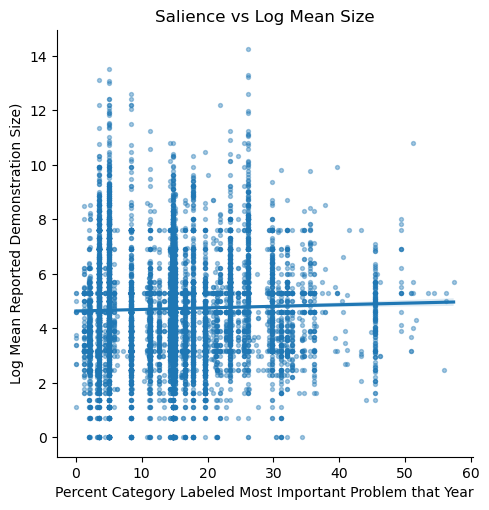

In [275]:
sns.lmplot(x = 'perc', y = target_cont,   
            data = demo_data,
            fit_reg = True, scatter_kws={'alpha': 0.4, 's': 8 })
plt.xlabel("Percent Category Labeled Most Important Problem that Year")
plt.ylabel("Log Mean Reported Demonstration Size)")
plt.title("Salience vs Log Mean Size")
plt.show()

#### Linear Model

In [276]:
ols_log_size_mean_by_perc = ols(formula = 'log_size_mean ~ perc', data = demo_data)
ols_log_size_mean_by_perc_fit = ols_log_size_mean_by_perc.fit()
print( ols_log_size_mean_by_perc_fit.summary() )

                            OLS Regression Results                            
Dep. Variable:          log_size_mean   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     11.77
Date:                Thu, 11 Dec 2025   Prob (F-statistic):           0.000604
Time:                        13:26:28   Log-Likelihood:                -29713.
No. Observations:               15133   AIC:                         5.943e+04
Df Residuals:                   15131   BIC:                         5.945e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6357      0.028    164.644      0.0

Despite having an $R^2$ of 0.001, the $F$-statistic is at 11.73—highly significant. Indeed, both the intercept and perc have very small p-values.

In other words, though the percent category labeled Most Important Problem that year does not explain nearly any of the variance in the log mean reported size of demonstrations, it is nevertheless explaining some of it.

In [277]:
ols_log_size_mean_by_perc_pop = ols(formula = 'log_size_mean ~ perc + DP05_0001PE', data = demo_data)
ols_log_size_mean_by_perc_pop_fit = ols_log_size_mean_by_perc_pop.fit()
print( ols_log_size_mean_by_perc_pop_fit.summary() )

                            OLS Regression Results                            
Dep. Variable:          log_size_mean   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     36.42
Date:                Thu, 11 Dec 2025   Prob (F-statistic):           1.66e-16
Time:                        13:26:28   Log-Likelihood:                -29683.
No. Observations:               15133   AIC:                         5.937e+04
Df Residuals:                   15130   BIC:                         5.939e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.5692      0.029    155.623      

Adding in population greatly boosts the predictive power.

In [278]:
# ols_log_size_mean_by_all = ols(formula = 'log_size_mean ~ .', data = demo_data)
# ols_log_size_mean_by_all_fit = ols_log_size_mean_by_all.fit()
# print( ols_log_size_mean_by_all.summary() )

In [279]:
demo_lm = LinearRegression()  # instantiate
demo_lm.fit(X_train, y_train_cont)
print("R^2 (with the test set):", demo_lm.score(X_test, y_test_cont))
print("R^2 (with the train set):", demo_lm.score(X_train, y_train_cont))

R^2 (with the test set): 0.042764615932398
R^2 (with the train set): 0.28133855968029664


The linear model with all variables overfits; worse than the null model.

##### LASSO Regression

"The advantage of using a cross-validation estimator over the canonical estimator class along with grid search is that they can take advantage of warm-starting by reusing precomputed results in the previous steps of the cross-validation process. This generally leads to speed improvements" (https://scikit-learn.org/stable/glossary.html#term-cross-validation-estimator).

In [280]:
demo_lasso = LassoCV(n_alphas=100, max_iter=10000, random_state=seed, n_jobs=6)
demo_lasso.fit(X_train, y_train_cont)

print('LASSO Regression model accuracy (with the test set):', demo_lasso.score(X_test, y_test_cont))
print('LASSO Regression model accuracy (with the train set):', demo_lasso.score(X_train, y_train_cont))

LASSO Regression model accuracy (with the test set): 0.17273548327115795
LASSO Regression model accuracy (with the train set): 0.23152201789832516


In [281]:
# pd.DataFrame([feature_names, demo_lasso.coef_]).T.rename(columns={0:"var_name",1:"coef"}).set_index("var_name").sort_values(by="coef")

lasso_coefs = pd.Series(demo_lasso.coef_,index=feature_names, name="coef")
lasso_coefs_sort = pd.DataFrame([lasso_coefs,lasso_coefs.abs().rename("abs_coef")]).T.sort_values("abs_coef",ascending=False)
lasso_coefs_sort = lasso_coefs_sort[lasso_coefs_sort["coef"] != 0]
lasso_coefs_sort.head(60)

coef  abs_coef
type_march                               0.438333  0.438333
type_protest                            -0.304985  0.304985
problemname_Public Safety                0.168577  0.168577
problemname_Rights                       0.143290  0.143290
problemname_Fiscal Policy                0.141170  0.141170
type_parade                              0.128362  0.128362
problemname_Politics                     0.103969  0.103969
problemname_Foreign Policy              -0.096764  0.096764
type_counterprotest                     -0.095642  0.095642
type_walk-out                            0.094778  0.094778
DP02_0061PE                             -0.078669  0.078669
DP04_0080PE                              0.058032  0.058032
type_hunger strike                      -0.057869  0.057869
perc                                     0.056460  0.056460
type_kneeling protest                   -0.055056  0.055056
NAME_Kanawha County, West Virginia       0.044903  0.044903
year                                     0.042981  0.042981
NAME_Bergen County, New Jersey          -0.040055  0.040055
NAME_Talladega County, Alabama          -0.037649  0.037649
DP04_0002PE                              0.037046  0.037046
DP02_0151PE                              0.033576  0.033576
NAME_Cobb County, Georgia               -0.033046  0.033046
DP02_0069PE                             -0.031530  0.031530
DP04_0041PE                              0.031184  0.031184
problemname_Social Policy                0.031180  0.031180
problemname_Morality                     0.029778  0.029778
type_resignation                        -0.029302  0.029302
NAME_Ingham County, Michigan             0.029251  0.029251
type_mass                               -0.029185  0.029185
DP03_0053PE                             -0.027250  0.027250
DP03_0077PE                             -0.026508  0.026508
type_festival                            0.026372  0.026372
type_sit-in                             -0.026358  0.026358
NAME_Prince George's County, Maryland   -0.025502  0.025502
type_mock execution                     -0.025479  0.025479
NAME_Ramsey County, Minnesota            0.025298  0.025298
DP04_0061PE                             -0.025139  0.025139
DP04_0059PE                              0.024777  0.024777
type_counter protest                    -0.024269  0.024269
type_aircraft flyover                   -0.024157  0.024157
type_protest vandalism                  -0.022766  0.022766
NAME_Baldwin County, Alabama            -0.022539  0.022539
NAME_Wilson County, North Carolina      -0.022480  0.022480
type_art projection                     -0.022398  0.022398
NAME_Faulkner County, Arkansas          -0.021370  0.021370
NAME_Grayson County, Texas              -0.021334  0.021334
NAME_Paulding County, Georgia           -0.020895  0.020895
DP02_0090PE                             -0.020705  0.020705
NAME_Santa Clara County, California      0.020581  0.020581
NAME_Hillsborough County, New Hampshire -0.020524  0.020524
type_self-immolation protest            -0.020523  0.020523
type_direct action                      -0.020466  0.020466
type_silent protest                     -0.020428  0.020428
type_die-in                             -0.020321  0.020321
NAME_Bartow County, Georgia             -0.020128  0.020128
NAME_Sarasota County, Florida            0.020021  0.020021
NAME_Chaves County, New Mexico          -0.019949  0.019949
NAME_Loudoun County, Virginia           -0.019846  0.019846
NAME_Jefferson County, Arkansas         -0.019801  0.019801
NAME_Spartanburg County, South Carolina -0.018993  0.018993

#### Logistic Regression

In [282]:
demo_logit = LogisticRegression(penalty="l2", C=1, random_state=seed, max_iter=1000)
demo_logit.fit(X_train, y_train_cat)
# Cross-validation
kfold = KFold(5, random_state = seed, shuffle = True)
grid_logit = GridSearchCV(demo_logit, {'C': [0.001, 0.01, 0.1, 1, 5, 10, 100]}, cv = kfold, scoring = "accuracy", n_jobs=6)
grid_logit.fit(X_train, y_train_cat)

print( grid_logit.best_params_ )
print( grid_logit.cv_results_[('mean_test_score')] )

demo_logit = grid_logit.best_estimator_

print('Logit model accuracy (with the test set):', demo_logit.score(X_test, y_test_cat))
print('Logit model accuracy (with the train set):', demo_logit.score(X_train, y_train_cat))

{'C': 0.001}
[0.55798745 0.55749127 0.55567429 0.55162671 0.54914874 0.54749663
 0.54667083]
Logit model accuracy (with the test set): 0.5609514370664024
Logit model accuracy (with the train set): 0.6141582686271271


### Tree

#### Regression Tree

In [283]:
demo_dtr = DecisionTreeRegressor(max_depth=3, random_state=seed)
demo_dtr.fit(X_train,y_train_cont)
demo_dtr.score(X_test,y_test_cont)

0.15357201823728905

Run cross-validation to choose the best `max_depth` and `criterion`.

In [284]:
param_grid_dtr = {'max_depth': range(3, 15)}
                 #'criterion':('absolute_error', 'squared_error', 'friedman_mse', 'poisson')} 
# Cross-validation
grid_dtr = GridSearchCV(demo_dtr, param_grid_dtr, cv = kfold, scoring = None, n_jobs=6)
grid_dtr.fit(X_train, y_train_cont)

print( grid_dtr.best_params_ )
print( grid_dtr.cv_results_[('mean_test_score')] )
demo_dtr = grid_dtr.best_estimator_

{'max_depth': 4}
[ 0.15427641  0.17541476  0.17179642  0.16702332  0.14898642  0.11507915
  0.07250315  0.03277081 -0.00644088 -0.04971834 -0.07389028 -0.11400164]


In [285]:
demo_dtr.score(X_test,y_test_cont)

0.17649969590118297

Tree does decently well, even on the test data.

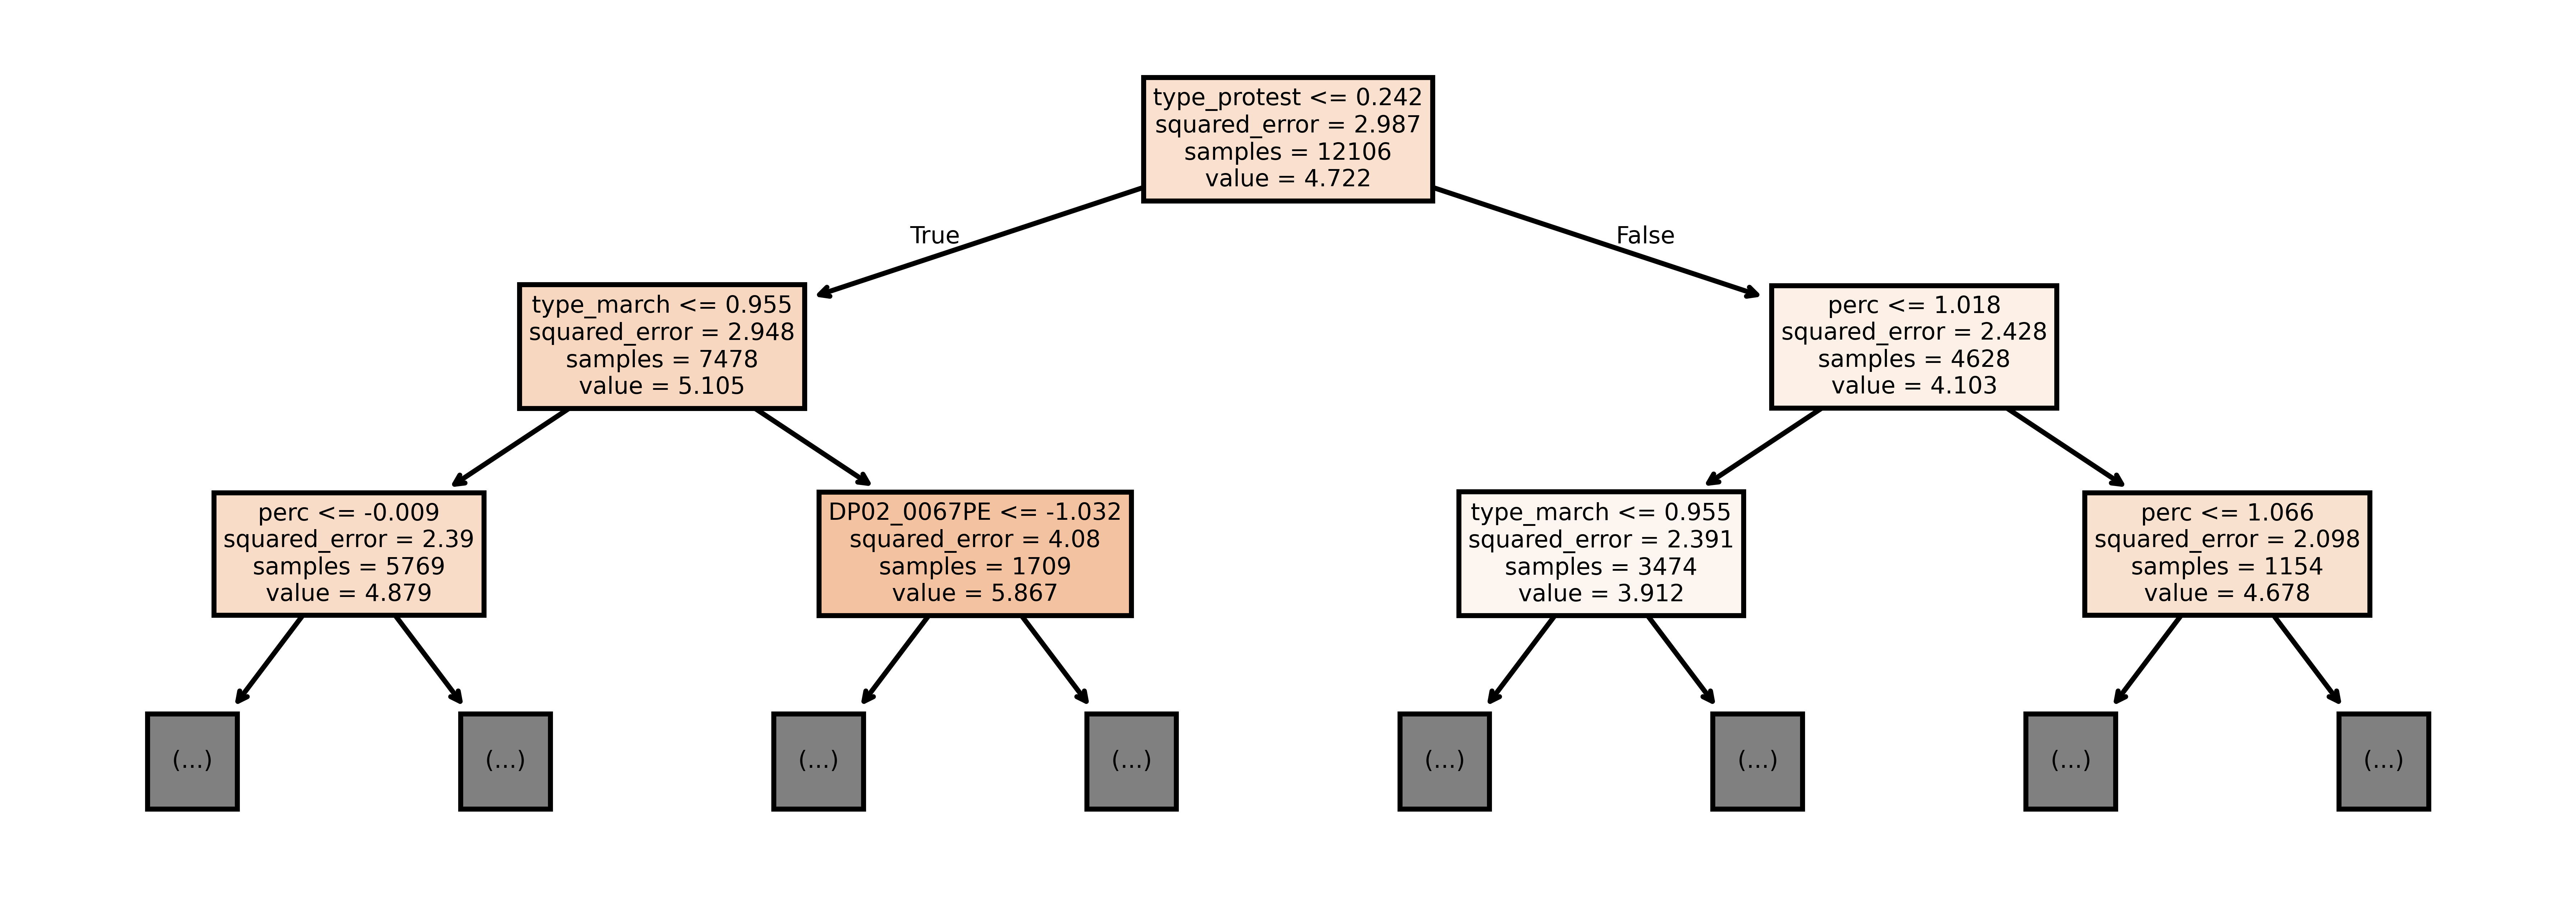

In [286]:
plt.figure(dpi=1000,figsize=(9,3))
plot_tree(demo_dtr, feature_names = np.setdiff1d(demo_train.columns, targets), filled=True, max_depth=2)
plt.show()

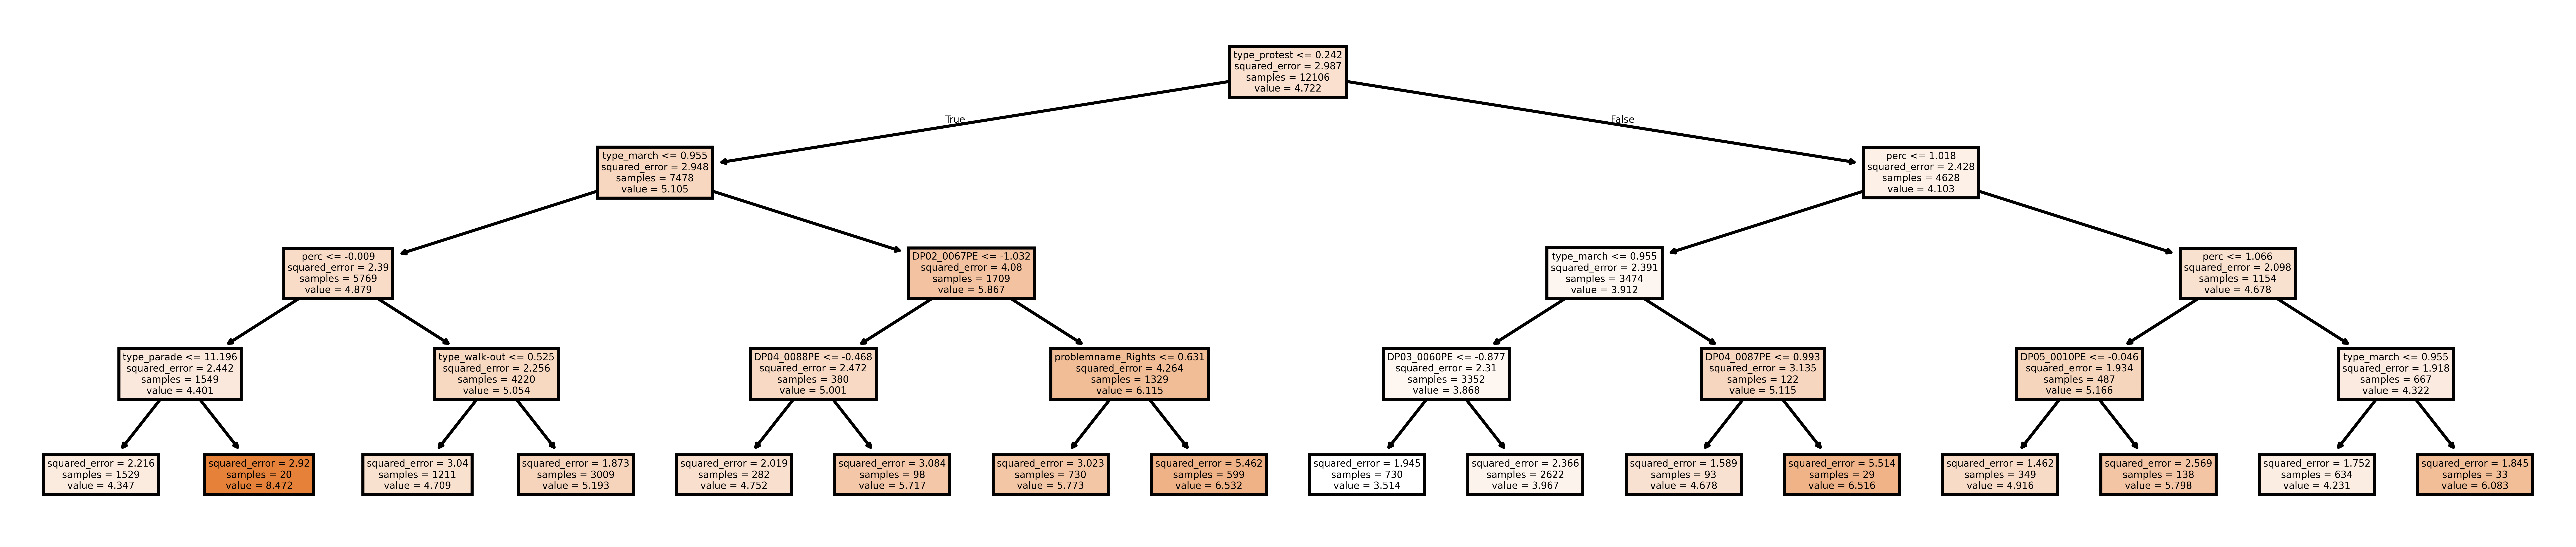

In [287]:
plt.figure(dpi=1000,figsize=(15,3))
plot_tree(demo_dtr, feature_names = np.setdiff1d(demo_train.columns, targets), filled=True)
plt.show()

`type_protest`, `type_march`, and `perc` were the three most important variables. Other important ones include `DP03_0087PE` (Mean family income in 2024 inflation-adjusted dollars)—higher has larger crowds—and `DP04_0088PE` (Percent of owner-occupied units that are worth $1,000,000 or more)—higher has larger crowds.

#### Classification Tree

In [288]:
demo_dtc = DecisionTreeClassifier(max_depth=3, random_state=seed)
demo_dtc.fit(X_train,y_train_cat)
demo_dtc.score(X_test,y_test_cat)

0.5850677238189627

In [289]:
param_grid_dtc = {'max_depth': range(3, 15, 2),
                  "criterion":("gini","entropy","log_loss")}
# Cross-validation
grid_dtc = GridSearchCV(demo_dtc, param_grid_dtc, cv = kfold, scoring = "accuracy", n_jobs=6)
grid_dtc.fit(X_train, y_train_cat)

print( grid_dtc.best_params_ )
print( grid_dtc.cv_results_[('mean_test_score')] )
demo_dtc = grid_dtc.best_estimator_

{'criterion': 'entropy', 'max_depth': 5}
[0.56996457 0.56889002 0.5721939  0.55856473 0.54890057 0.54642321
 0.55583995 0.57392957 0.56335577 0.55972053 0.54510014 0.53898727
 0.55583995 0.57392957 0.56335577 0.55972053 0.54510014 0.53898727]


In [290]:
demo_dtc.score(X_test,y_test_cat)

0.5910142054839775

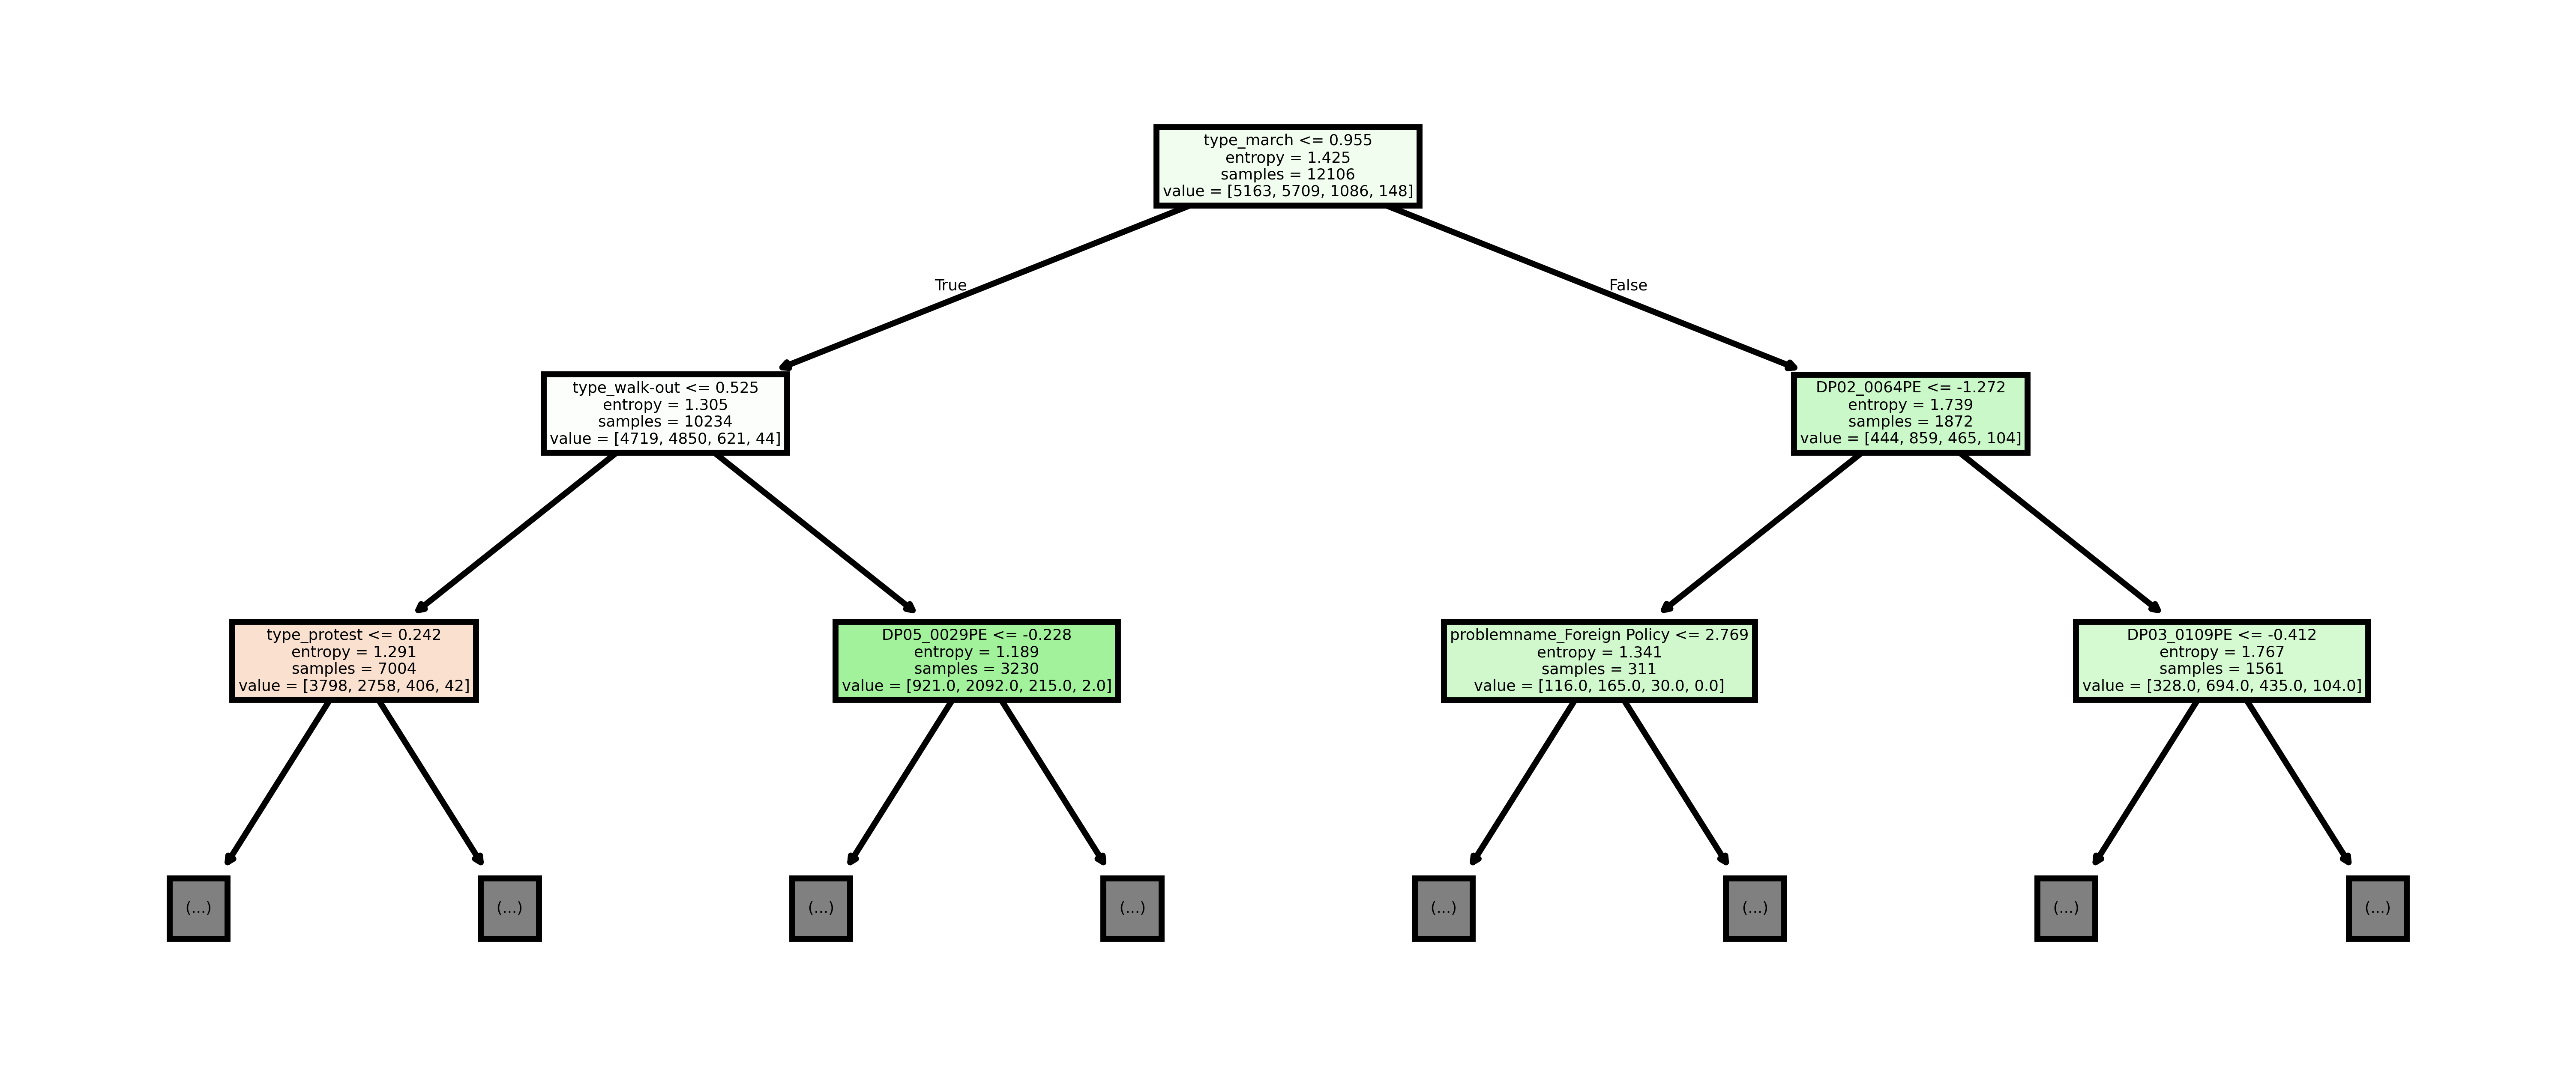

In [291]:
plt.figure(dpi=1000,figsize=(7.5,3))
plot_tree(demo_dtc, feature_names = np.setdiff1d(demo_train.columns, targets), filled=True, max_depth=2)
plt.show()

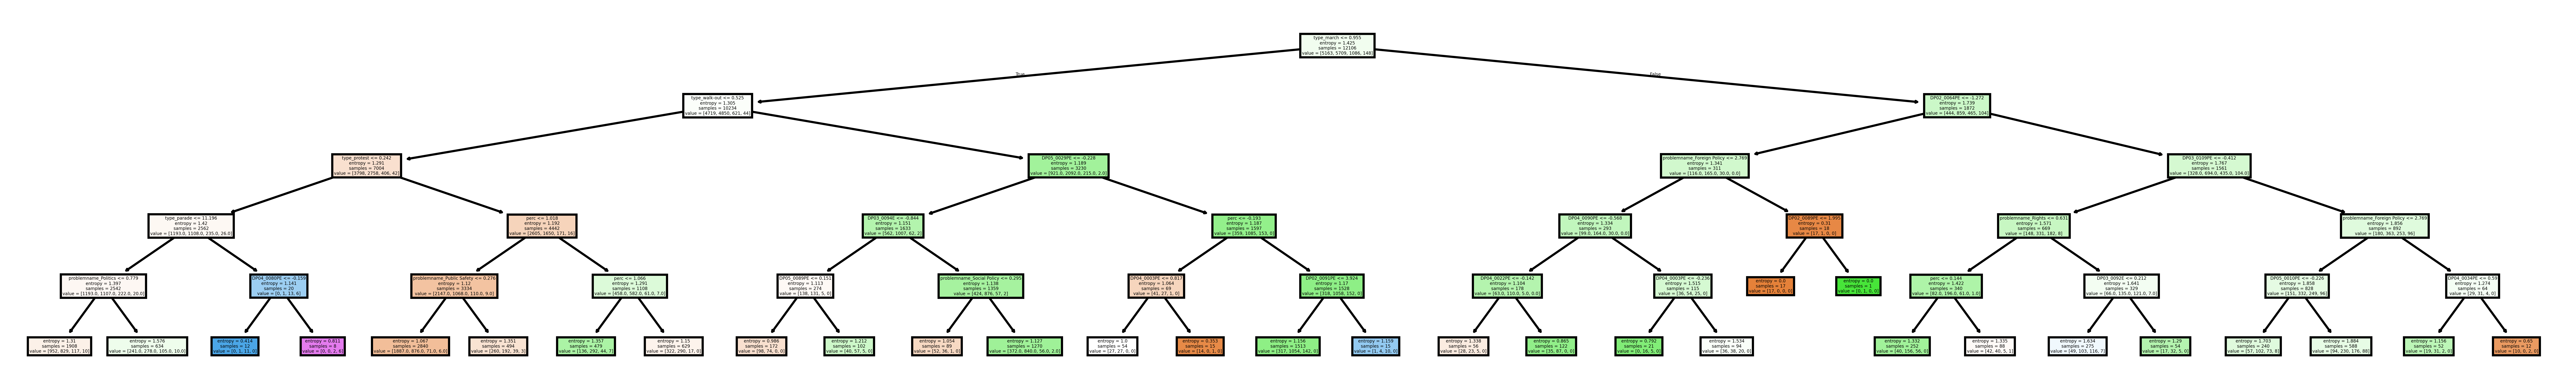

In [292]:
plt.figure(dpi=1000,figsize=(21,3))
plot_tree(demo_dtc, feature_names=np.setdiff1d(demo_train.columns, targets), filled=True)
plt.show()

`type_protest`, `type_walk-out`, `walk-out`, and `perc` were the three most important variables. Other important ones include `type_march`, `problemname_Social Policy`.

Interesting to note are `DP02_0123PE` (percent of the population 5 years or older that speaks a language at home other than English and that speaks English less than "very well")—higher percents have larger protests—and `DP02_0031PE` (percent of females 15 years old or older who are married)—higher percents have larger protests.

### Random Forest

#### Random Forest Regression

In [293]:
demo_rfr = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=seed, n_jobs=6)  # instantiate
demo_rfr.fit(X_train, y_train_cont)

print("R^2 (with the test data):", demo_rfr.score(X_test, y_test_cont))

R^2 (with the test data): 0.16889189209025635


In [294]:
param_grid_rf = {
    'max_depth': [3, 5, 7, 9, 11],
    'n_estimators': [5, 10, 15, 20, 25, 30]
} 
# Cross-validation
grid_rfr = GridSearchCV(demo_rfr, param_grid_rf, cv = kfold, scoring = None, n_jobs=6)
grid_rfr.fit(X_train, y_train_cont)

print( grid_rfr.best_params_ )
print( grid_rfr.cv_results_[('mean_test_score')] )
demo_rfr = grid_rfr.best_estimator_

{'max_depth': 7, 'n_estimators': 30}
[0.16530795 0.16770009 0.16790283 0.16854292 0.16871062 0.1683927
 0.19821715 0.20514605 0.20707459 0.2083553  0.20810933 0.20910525
 0.19486511 0.20848912 0.2131116  0.21583924 0.2165475  0.2181381
 0.18017232 0.19947351 0.20693605 0.21016008 0.21338016 0.21534464
 0.15067159 0.18217935 0.19052761 0.19475678 0.19996667 0.20249005]


Best: max depth 7, 30 estimators

In [295]:
print("R^2 (with the test data):", demo_rfr.score(X_test, y_test_cont) )

R^2 (with the test data): 0.2231426252546519


In [296]:
rfr_feature_imp = pd.DataFrame({'Feature': feature_names, 'Gini Importance': demo_rfr.feature_importances_}).sort_values(
    'Gini Importance', ascending=False)
rfr_feature_imp = rfr_feature_imp.merge(census_vars[["VARIABLE","LABEL"]], how="left", left_on="Feature", right_on="VARIABLE").drop(columns="VARIABLE").fillna("")
rfr_feature_imp.head(20)

Feature  Gini Importance  \
0                 type_protest         0.211848   
1                   type_march         0.150337   
2                         perc         0.107702   
3                  type_parade         0.027757   
4                type_walk-out         0.027299   
5           problemname_Rights         0.023090   
6    problemname_Fiscal Policy         0.019479   
7                  DP02_0067PE         0.018525   
8                  DP05_0010PE         0.013239   
9                   type_rally         0.009304   
10         type_counterprotest         0.007802   
11        problemname_Politics         0.007586   
12                 DP02_0061PE         0.006558   
13                 DP05_0029PE         0.006492   
14                 DP03_0114PE         0.006269   
15                 DP04_0054PE         0.006246   
16   problemname_Public Safety         0.005976   
17                 DP02_0064PE         0.005715   
18  problemname_Foreign Policy         0.005683   
19                 DP04_0042PE         0.005675   

                                                                                                              LABEL  
0                                                                                                                    
1                                                                                                                    
2                                                                                                                    
3                                                                                                                    
4                                                                                                                    
5                                                                                                                    
6                                                                                                                    
7                                              Percent!!EDUCATIONAL ATTAINMENT!!Percent bachelor's degree or higher  
8                                                                              Percent!!SEX AND AGE!!25 to 34 years  
9                                                                                                                    
10                                                                                                                   
11                                                                                                                   
12       Percent!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!High school graduate (includes equivalency)  
13                                                                          Percent!!SEX AND AGE!!65 years and over  
14  Percent!!HEALTH INSURANCE COVERAGE!!Civilian noninstitutionalized population 19 to 64 years!!Not in labor force  
15                         Percent!!YEAR HOUSEHOLDER MOVED INTO UNIT!!Occupied housing units!!Moved in 1990 to 1999  
16                                                                                                                   
17                                 Percent!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree  
18                                                                                                                   
19                                                               Percent!!BEDROOMS!!Total housing units!!3 bedrooms

New information: `DP02_0064PE` (percent of the population 25 years old or older that has graduated from high school or the equivalent) and `DP02_0061PE` (percent of the population 25 years old or older that has a 9th–12th-grade education without a high school diploma) are also important, as is local effects (a la the categorical `FIPS Code`). Rounding out the top 20 are `DP03_0085PE` (percent of families whose income and benefits (in 2024 inflation-adjusted dollars) equal or exceed $200,000), `DP02_0065PE

#### Random Forest Classification

In [297]:
demo_rfc = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=seed, n_jobs=6)  # instantiate
demo_rfc.fit(X_train, y_train_cat)

print('RFC model accuracy (with the test set):', demo_rfc.score(X_test, y_test_cat))
print('RFC model accuracy (with the train set):', demo_rfc.score(X_train, y_train_cat))

RFC model accuracy (with the test set): 0.5229600264288073
RFC model accuracy (with the train set): 0.5431191144886833


In [298]:
# Cross-validation
grid_rfc = GridSearchCV(demo_rfc, param_grid_rf, cv = kfold, scoring = None, n_jobs=6)
grid_rfc.fit(X_train, y_train_cat)

print( grid_rfc.best_params_ )
print( grid_rfc.cv_results_[('mean_test_score')])
demo_rfc = grid_rfc.best_estimator_

{'max_depth': 9, 'n_estimators': 30}
[0.50693928 0.51164634 0.51652097 0.52205516 0.52238536 0.52800236
 0.51338096 0.5236235  0.53023247 0.53287577 0.5332893  0.53675812
 0.51362971 0.52263336 0.52428571 0.53048133 0.52990363 0.5358507
 0.5246989  0.52932403 0.53271072 0.53221526 0.53395022 0.53700667
 0.51585954 0.5232937  0.52585439 0.53163716 0.53213275 0.53403225]


In [299]:
print("Accuracy (with the test data):", demo_rfc.score(X_test, y_test_cat) )

Accuracy (with the test data): 0.5490584737363726


In [300]:
rfc_feature_imp = pd.DataFrame({'Feature': feature_names, 'Gini Importance': demo_rfc.feature_importances_}).sort_values(
    'Gini Importance', ascending=False)
rfc_feature_imp = rfc_feature_imp.merge(census_vars[["VARIABLE","LABEL"]], how="left", left_on="Feature", right_on="VARIABLE").drop(columns="VARIABLE").fillna("")
rfc_feature_imp.head(20)

Feature  Gini Importance  \
0                type_protest         0.062471   
1               type_walk-out         0.048473   
2                        perc         0.038086   
3                  type_march         0.035311   
4   problemname_Social Policy         0.029801   
5   problemname_Public Safety         0.024623   
6                 DP04_0051PE         0.009591   
7          problemname_Rights         0.007978   
8                  type_rally         0.007440   
9                 DP04_0052PE         0.006895   
10  problemname_Fiscal Policy         0.006775   
11        problemname_Economy         0.006578   
12       problemname_Politics         0.006418   
13                DP04_0054PE         0.006228   
14                DP04_0055PE         0.005819   
15                 DP03_0087E         0.005785   
16                DP04_0053PE         0.005723   
17                 DP03_0067E         0.005605   
18                 DP04_0109E         0.005207   
19                 DP03_0094E         0.004954   

                                                                                                                                     LABEL  
0                                                                                                                                           
1                                                                                                                                           
2                                                                                                                                           
3                                                                                                                                           
4                                                                                                                                           
5                                                                                                                                           
6                                                Percent!!YEAR HOUSEHOLDER MOVED INTO UNIT!!Occupied housing units!!Moved in 2015 or later  
7                                                                                                                                           
8                                                                                                                                           
9                                                 Percent!!YEAR HOUSEHOLDER MOVED INTO UNIT!!Occupied housing units!!Moved in 2010 to 2014  
10                                                                                                                                          
11                                                                                                                                          
12                                                                                                                                          
13                                                Percent!!YEAR HOUSEHOLDER MOVED INTO UNIT!!Occupied housing units!!Moved in 1990 to 1999  
14                                                Percent!!YEAR HOUSEHOLDER MOVED INTO UNIT!!Occupied housing units!!Moved in 1980 to 1989  
15                              Estimate!!INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS)!!Families!!Mean family income (dollars)  
16                                                Percent!!YEAR HOUSEHOLDER MOVED INTO UNIT!!Occupied housing units!!Moved in 2000 to 2009  
17         Estimate!!INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS)!!With Social Security!!Mean Social Security income (dollars)  
18                                       Estimate!!SELECTED MONTHLY OWNER COSTS (SMOC)!!Housing units without a mortgage!!Median (dollars)  
19  Estimate!!INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS)!!Median earnings for female full-time, year-round workers (dollars)

Here, we see entirely different demographic variables: for some reason, the percent of occupied housing units moved into in different decades continuese to be significant.

### K Nearest Neighbors

#### K Nearest Neighbors Regression

In [301]:
demo_knnr = KNeighborsRegressor()
param_grid_knn = {'n_neighbors': range(1,31)} 
# Cross-validation
grid_knnr = GridSearchCV(demo_knnr, param_grid_knn, cv = kfold, scoring = None, n_jobs=6)
grid_knnr.fit(X_train, y_train_cont)

print( grid_knnr.best_params_ )
print( grid_knnr.cv_results_[('mean_test_score')] )
demo_knnr=grid_knnr.best_estimator_

{'n_neighbors': 29}
[-6.93281057e-01 -2.92231569e-01 -1.66642711e-01 -1.04816958e-01
 -6.80145105e-02 -4.39656171e-02 -2.74694373e-02 -1.98939267e-02
 -1.33587513e-02 -6.79451491e-04  3.43898735e-03  7.85792948e-03
  1.11042459e-02  1.27858748e-02  1.49968302e-02  1.94702889e-02
  2.08537607e-02  2.06767612e-02  2.20331481e-02  2.29842905e-02
  2.28393239e-02  2.26654688e-02  2.26495905e-02  2.31892275e-02
  2.24552154e-02  2.46215018e-02  2.42134857e-02  2.61699761e-02
  2.62851297e-02  2.59752936e-02]


In [302]:
print("R^2 (with the test data):", demo_knnr.score(X_test, y_test_cont) )

R^2 (with the test data): 0.00835429019177314


KNN tried its best, but it is not the correct model to use here.

#### K Nearest Neighbors Classification

In [303]:
demo_knnc = KNeighborsClassifier()
# Cross-validation
grid_knnc = GridSearchCV(demo_knnc, param_grid_knn, cv = kfold, scoring = "accuracy", n_jobs=6)
grid_knnc.fit(X_train, y_train_cat)

print( grid_knnc.best_params_ )
print( grid_knnc.cv_results_[('mean_test_score')] )
demo_knnc=grid_knnc.best_estimator_

{'n_neighbors': 17}
[0.46555446 0.48777505 0.49397066 0.49818271 0.49545683 0.49917465
 0.50107486 0.5046267  0.50289144 0.50826136 0.50718677 0.50826129
 0.50867397 0.50966492 0.51148218 0.50941739 0.51214231 0.50867379
 0.50569975 0.50594785 0.51049143 0.50784745 0.50974742 0.50916918
 0.51090366 0.50660778 0.50925111 0.50619476 0.50776467 0.50636019]


In [304]:
print("Accuracy (with the test data):", demo_knnc.score(X_test, y_test_cat) )

Accuracy (with the test data): 0.49289725801123224


Barely better than chance.

## Dimensionality Reduction

### Primary Component Analysis (PCA)

In [305]:
# # PCA Computations
# X_avg = np.mean(X_train, axis = 0)
# B = X_train - np.tile(X_avg, (len(X_train), 1))

# U, S, VT = np.linalg.svd(B / np.sqrt(len(X_train)), full_matrices=True)
# V = VT.T

# #t = np.arange(0, 1, 0.1)
# # plt.plot(t, V[1, 0]/V[0, 0] * t)
# # plt.plot(t, V[1, 1]/V[0, 1] * t)
# plt.quiver([X_avg[0], X_avg[0]], [X_avg[1],X_avg[1]], V[0,:], V[1,:], scale=8, zorder=2, color=['b', 'r'])
# plt.show()

# theta = 2 * np.pi * np.arange(0, 1, 0.01)
# Xstd = np.array([np.cos(theta), np.sin(theta)]).T @ np.diag(S) @ VT

# plt.plot(X_avg[0] +     Xstd[:, 0], X_avg[1] +     Xstd[:,1])
# plt.plot(X_avg[0] + 2 * Xstd[:, 0], X_avg[1] + 2 * Xstd[:,1])
# plt.plot(X_avg[0] + 3 * Xstd[:, 0], X_avg[1] + 3 * Xstd[:,1])
# plt.show()

In [306]:
demo_pca = PCA(n_components=0.95)  # Retain 90% of variance
demo_pca.fit(X_train)

X_train_pca = demo_pca.transform(X_train)
X_test_pca = demo_pca.transform(X_test)

In [307]:
pca_lm = LinearRegression()
pca_lm.fit(X_train_pca,y_train_cont)

print("R^2 (with the test set):", pca_lm.score(X_test_pca, y_test_cont))
print("R^2 (with the train set):", pca_lm.score(X_train_pca, y_train_cont))

R^2 (with the test set): 0.07789234638581732
R^2 (with the train set): 0.18730111311333475


In [308]:
pca_logit = LogisticRegression(penalty="l2", C=1, random_state=seed, max_iter=10000)
pca_logit.fit(X_train_pca,y_train_cat)

# Cross-validation
grid_logit = GridSearchCV(pca_logit, {'C': [0.001, 0.01, 0.1, 1, 5, 10, 100]}, cv = kfold, scoring = "accuracy", n_jobs=6)
grid_logit.fit(X_train_pca, y_train_cat)

print( grid_logit.best_params_ )
print( grid_logit.cv_results_[('mean_test_score')] )

pca_logit = grid_logit.best_estimator_

print('Logit model accuracy (with the test set):', pca_logit.score(X_test_pca, y_test_cat))
print('Logit model accuracy (with the train set):', pca_logit.score(X_train_pca, y_train_cat))

{'C': 1}
[0.53981464 0.54956162 0.55137943 0.5531137  0.55022247 0.54881803
 0.54914789]
Logit model accuracy (with the test set): 0.5523620746613809
Logit model accuracy (with the train set): 0.6225012390550141


In [309]:
print("Logit Classification\n", classification_report( y_test_cat, pca_logit.predict(X_test_pca) ) )

Logit Classification
               precision    recall  f1-score   support

           1       0.58      0.56      0.57      1291
           2       0.55      0.62      0.59      1428
           3       0.33      0.17      0.22       271
           4       0.33      0.22      0.26        37

    accuracy                           0.55      3027
   macro avg       0.45      0.39      0.41      3027
weighted avg       0.54      0.55      0.54      3027



## Model Evaluation

### Check performance metrics like Accuracy, Precision, F1-score, Recall.

In [310]:
print("Logit Classification\n", classification_report( y_test_cat, demo_logit.predict(X_test), zero_division=0.0 ) )
print("Logit Classification with PCA\n", classification_report( y_test_cat, pca_logit.predict(X_test_pca) ) )
print("Decision Tree Classification\n", classification_report( y_test_cat, demo_dtc.predict(X_test), zero_division=0.0 ) )
print("Random Forest Classification\n", classification_report( y_test_cat, demo_rfc.predict(X_test), zero_division=0.0 ) )
print("K Nearest Neighbors Classification\n", classification_report( y_test_cat, demo_knnc.predict(X_test), zero_division=0.0 ) )

Logit Classification
               precision    recall  f1-score   support

           1       0.58      0.57      0.57      1291
           2       0.55      0.66      0.60      1428
           3       0.41      0.06      0.11       271
           4       0.00      0.00      0.00        37

    accuracy                           0.56      3027
   macro avg       0.39      0.32      0.32      3027
weighted avg       0.54      0.56      0.54      3027

Logit Classification with PCA
               precision    recall  f1-score   support

           1       0.58      0.56      0.57      1291
           2       0.55      0.62      0.59      1428
           3       0.33      0.17      0.22       271
           4       0.33      0.22      0.26        37

    accuracy                           0.55      3027
   macro avg       0.45      0.39      0.41      3027
weighted avg       0.54      0.55      0.54      3027

Decision Tree Classification
               precision    recall  f1-score   s

Recall of the biggest demonstration sizes is more important here, as it is better to allocate resources where they are not needed than to not when they are necessary. As such, though the best logistic regression model has a lower overall accuracy than the best decision tree classifier, as it is slightly better at predicting those larger demonstration sizes, that looks to be the best model. Additionally, as the logistic regression with PCA has resulted in slightly worse accuracy than without it, but with better results for categories 3 and 4, that should be taken as the best model for classification.

### Plot the One vs. Rest multiclass ROC-AUC curves for the best trained classifiers

ROC-AUC can only be applied to binary classifiers. As such, a One vs. Rest strategy may be used, plotting multiple curves: one for each class, where a failure is a classification of any of the others.

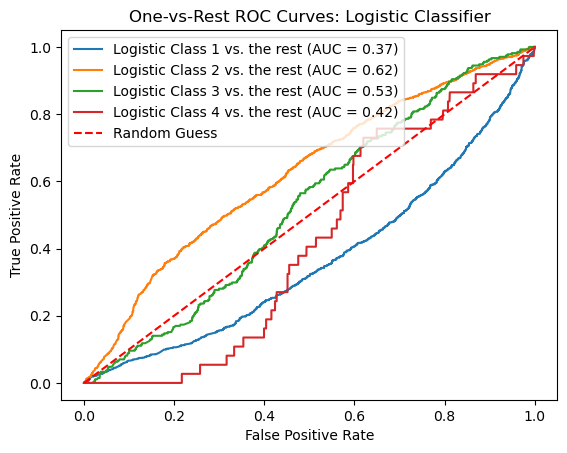

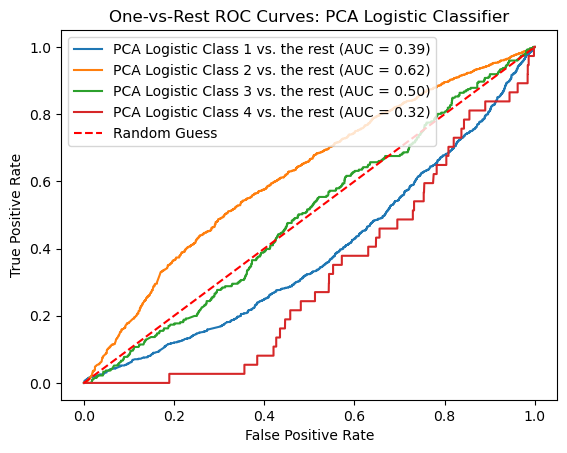

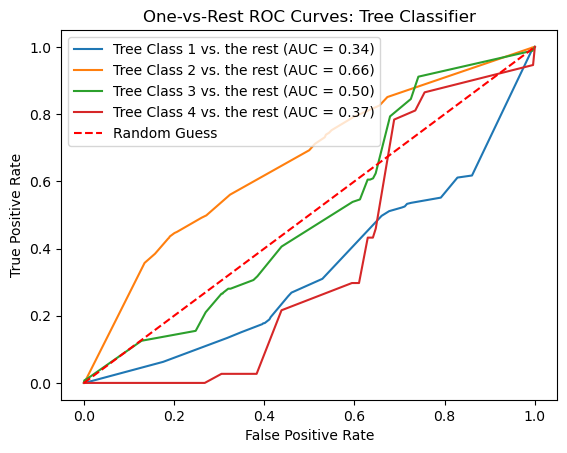

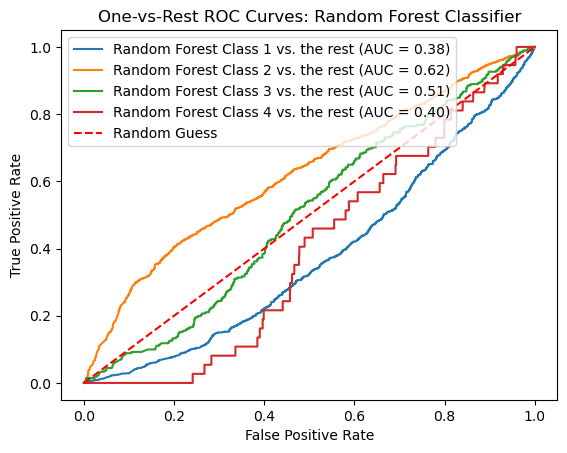

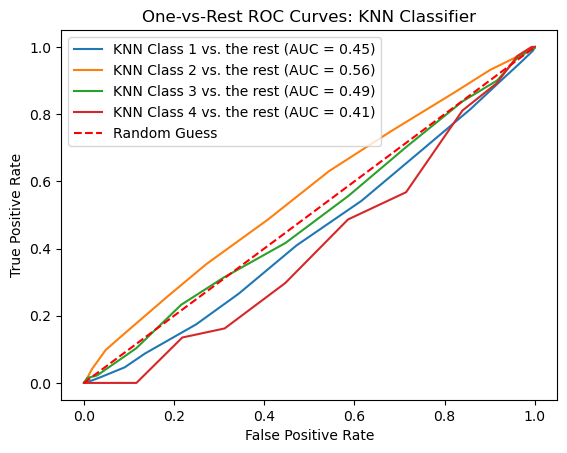

In [311]:
label_binarizer = LabelBinarizer().fit(y_train_cat) # sourced from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
y_test_cat_onehot = label_binarizer.transform(y_test_cat)
# y_test_cat_onehot.shape  # (n_samples, n_classes)

class_names=y_test_cat.unique().sort_values()

def OvR_ROC_AUC(X_test, y_test_onehot, cat_model, cat_model_name, classes, class_names):
    for class_of_interest in classes:
        class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
        
        fpr, tpr, _ = roc_curve(y_test_onehot[:, class_id], cat_model.predict_proba(X_test)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{cat_model_name} Class {class_names[class_id]} vs. the rest (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'One-vs-Rest ROC Curves: {cat_model_name} Classifier')
    plt.legend()
    plt.show()

OvR_ROC_AUC(X_test, y_test_cat_onehot, cat_model=demo_logit, cat_model_name="Logistic", classes=label_binarizer.classes_, class_names=class_names)
OvR_ROC_AUC(X_test_pca, y_test_cat_onehot, cat_model=pca_logit, cat_model_name="PCA Logistic", classes=label_binarizer.classes_, class_names=class_names)
OvR_ROC_AUC(X_test, y_test_cat_onehot, cat_model=demo_dtc, cat_model_name="Tree", classes=label_binarizer.classes_, class_names=class_names)
OvR_ROC_AUC(X_test, y_test_cat_onehot, cat_model=demo_rfc, cat_model_name="Random Forest", classes=label_binarizer.classes_, class_names=class_names)
OvR_ROC_AUC(X_test, y_test_cat_onehot, cat_model=demo_knnc, cat_model_name="KNN", classes=label_binarizer.classes_, class_names=class_names)


# # Logit
# fpr, tpr, _ = roc_curve(y_test_cat, demo_logit.predict_proba(X_test)[:, 1])
# roc_auc = auc(fpr, tpr)
# plt.plot(fpr, tpr, label=f'Logistic (AUC = {roc_auc:.2f})')
# # Decision Tree
# fpr, tpr, _ = roc_curve(y_test_cat, demo_dtc.predict_proba(X_test)[:, 1])
# roc_auc = auc(fpr, tpr)
# plt.plot(fpr, tpr, label=f'Tree (AUC = {roc_auc:.2f})')
# # Random Forest
# fpr, tpr, _ = roc_curve(y_test_cat, demo_rfc.predict_proba(X_test)[:, 1])
# roc_auc = auc(fpr, tpr)
# plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})')
# # KNN
# fpr, tpr, _ = roc_curve(y_test_cat, demo_knnc.predict_proba(X_test)[:, 1])
# roc_auc = auc(fpr, tpr)
# plt.plot(fpr, tpr, label=f'KNN (AUC = {roc_auc:.2f})')

# plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curves for Two Models')
# plt.legend()
# plt.show()

Judging by the ROC-AUC curves, the best decision tree would appear to be the best model. It is the worst at predicting Class 1s, but as that is the smallest class, it is the least essential to distribute resources appropriately for.

It is worth comparing the logistic regression with the full dataset vs. the one flattened by PCA. Despite PCA being useful in the case of linear regression, for logistic regression, it instead produces worse results here for Classes 3 and 4.

### Plot the residuals for the best trained regressors

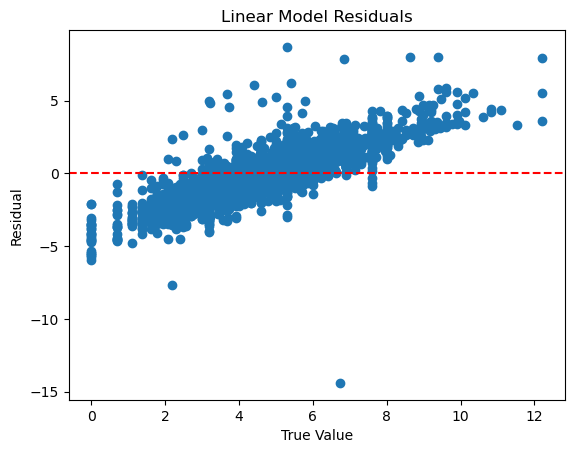

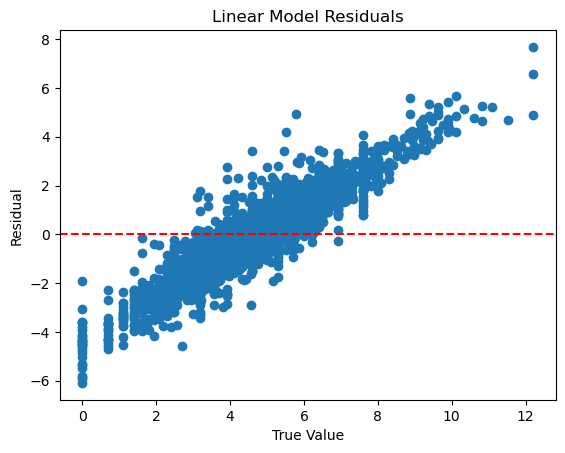

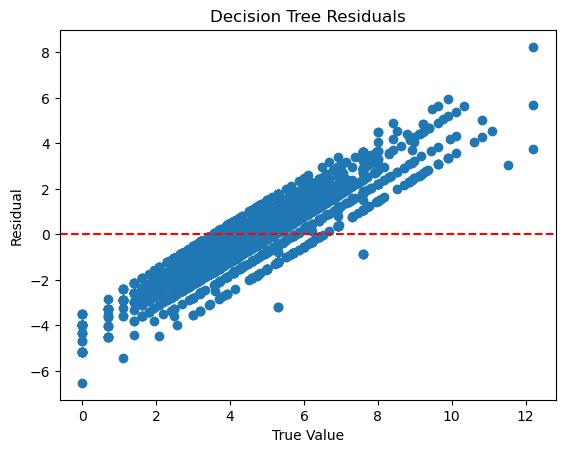

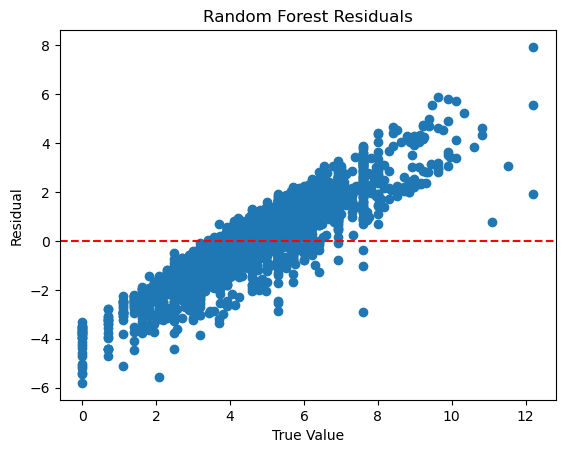

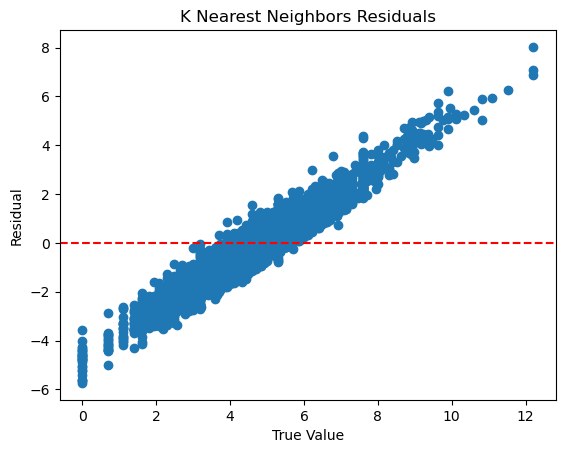

In [315]:
# linear model
plt.scatter(y_test_cont, y_test_cont - demo_lm.predict(X_test))
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("True Value")
plt.ylabel('Residual')
plt.title("Linear Model Residuals")
plt.show()

# linear model with PCA
plt.scatter(y_test_cont, y_test_cont - pca_lm.predict(X_test_pca))
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("True Value")
plt.ylabel('Residual')
plt.title("Linear Model Residuals")
plt.show()

# tree
plt.scatter(y_test_cont, y_test_cont - demo_dtr.predict(X_test))
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("True Value")
plt.ylabel('Residual')
plt.title("Decision Tree Residuals")
plt.show()

# random forest
plt.scatter(y_test_cont, y_test_cont - demo_rfr.predict(X_test))
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("True Value")
plt.ylabel('Residual')
plt.title("Random Forest Residuals")
plt.show()

# knn
plt.scatter(y_test_cont, y_test_cont - demo_knnr.predict(X_test))
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("True Value")
plt.ylabel('Residual')
plt.title("K Nearest Neighbors Residuals")
plt.show()

The residuals all have a clear direction. The linear model appears flattest, but only because it is squashed to show all of the residuals.

In [317]:
print("R^2 With the Test Data")
print(f"Linear Model: {demo_lm.score(X_test,y_test_cont):.2f}")
print(f"Linear Model with PCA: {pca_lm.score(X_test_pca,y_test_cont):.2f}")
print(f"Decision Tree: {demo_dtr.score(X_test,y_test_cont):.2f}")
print(f"Random Forest: {demo_rfr.score(X_test,y_test_cont):.2f}")
print(f"K Nearest Neighbors: {demo_knnr.score(X_test,y_test_cont):.2f}")

R^2 With the Test Data
Linear Model: 0.04
Linear Model with PCA: 0.08
Decision Tree: 0.18
Random Forest: 0.22
K Nearest Neighbors: 0.01


The best Random Forest model explains the most variance. The linear model with PCA explains twice the variance of the linear model without it. The KNN regressor, meanwhile, barely accounts for anything.

## Conclusions

When I began this project, I truly did not know whether or not my SMART question could be answered.